Diogo Pedrosa (202006947),

Sofia Avelino (202008485),

Pedro Pedrosa (201907366)

# Introduction

Recently, the healthcare industry has experienced a tremendous surge in the **volume of data** being generated and gathered. Conventional methods of **processing** and **storing** data are struggling to keep pace with the sheer **magnitude**, **speed**, and **diversity** of this influx of **big data**, necessitating innovative solutions.

**Big data analytics and cloud computing** have emerged as key technologies, providing scalable and efficient tools for handling, analyzing, and storing extensive datasets in healthcare.

This project focuses on predicting the length of **hospital stays** (LOS) using the **MIMIC-III** database. **MIMIC-III** is a publicly accessible database containing comprehensive clinical data from more than 40000 patients admitted to various ICUs (intensive care units).

Predicting LOS is crucial for effective hospital management, enabling healthcare providers to optimize resource allocation, as the goal is to develop a precise prediction model for LOS that can support healthcare professionals and hospital administrators.

Therefore in this project we aim to showcase the effectiveness of **big data analytics and cloud computing solutions** in extracting valuable insights from large-scale healthcare data.

## MIMIC-III Considerations

The complexity and the size of the database structure makes it impossible to be worked with standard data loading and processing methods. This data is dispersed across multiple tables such as **ADMISSIONS, CHARTEVENTS, DIAGNOSES_ICD**, and **ICUSTAYS**, which not only complicates traditional approaches like pandas for loading and preprocessing but also demands distributed and scalable solutions to handle the sheer volume effectively.

Given the initial storage of our dataset is in a **Google Cloud Platform** bucket, we decided to use Google's BigQuery as our solution. It not only facilitated the seamless loading and storage of data from the bucket but also provided robust capabilities for exploratory data analysis and further preparation of the dataset dataset for the predictive models to be trained.

As will be discussed further on, our **strategy** included **filtering** the data to focus on a subset of **specific diseases** or **diagnoses**. This filtering serves mainly as a practical technique for reducing **data complexity**, as varying medical conditions may necessitate distinct treatments and procedural pathways, which would complicate the model's learning task tremendously.

Before jumping into the initial exploratory data analysis itself, it's important to briefly explain how the initial database setup was made in **BigQuery**:

- We started by using a virtual machine from Google Cloud to retrieve the zipped files containing the data from the bucket we stored them in. The files were too large to unzip in the Google Cloud Shell, so we unzipped them on the virtual machine.

- After unzipping the files, we inserted them back into the bucket and used them to create the tables of our dataset in BigQuery.

- With the dataset tables created in BigQuery, we accessed the data through this notebook and proceeded to use it as intended.

Now, the following are the tables out of **MIMIC-III** that we selected:

 - **ADMISSIONS**: Records each hospital admission, including demographic details, admission and discharge dates, and insurance information.

 - **CHARTEVENTS**: Captures nursing chart notes for each patient, with the date, time, nursing category, and text of the note.

 - **D_ITEMS**: Lists medical items used in the hospital, including names, categories, and units of measure.

 - **DIAGNOSES_ICD**: Records diagnoses assigned to patients during their stay, including ICD-9 codes.

 - **ICUSTAYS**: Contains information about each ICU stay, including the admission and discharge
dates and times.

 - **PATIENTS**: Contains demographic information for each patient, including date of birth, gender, and ethnicity.

We'll now load all the necessary libraries and setup the **BigQuery's Client** to be used throughout the project to do all the necessary queries on the database containing the referred tables.


##Initial Notebook Setup






In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time


!pip install --upgrade google-cloud-bigquery
!pip install pyspark
#!pip install dask distributed --upgrade
!pip install dask[complete]
!pip install dask-ml[complete]
!pip install xgboost --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=b69378c9cb35a5ce715f0e11bb86aedd95ac1c11fe6a1c12820e48ff7ed4c305
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
  Using cached lz4-4.3.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.8/149.8 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 MB 7.9 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.0.3
    Uninstalling xgboost-2.0.3:
      Successfully uninstalled xgboost-2.0.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 8.4 MB/s eta 0:00:00
     ━

In [ ]:
# set project id
PROJECT_ID = 'preject-2-bdcc' #@param {type: "string"}

# google cloud authentication
from google.colab import auth
auth.authenticate_user()
!gcloud config set project {PROJECT_ID}

# bigquery client creation
import google.cloud.bigquery as bq
client = bq.Client(project=PROJECT_ID)

Updated property [core/project].


---


##Data Analysis and Visualization

This section involves gathering data from the MIMIC-III dataset and performing analysis using data aggregation techniques followed by visualization.

We can begin by obtaining the total number of distinct registered patients:

In [ ]:
%%bigquery --project $PROJECT_ID
SELECT COUNT(DISTINCT SUBJECT_ID) AS num_distinct_patients
FROM MIMIC.PATIENTS

Query is running:   0%|          |

Downloading:   0%|          |

,num_distinct_patients
0,46520


Since each patient may have been admitted multiple times, the number of admissions also provides us with relevant information:

In [ ]:
%%bigquery --project $PROJECT_ID
SELECT COUNT(DISTINCT HADM_ID) AS num_admissions
FROM MIMIC.ICUSTAYS

Query is running:   0%|          |

Downloading:   0%|          |

,num_admissions
0,57786


We can also compute other pertinent statistics related to admissions, such as maximum, minimum, mean, and median values, along with the count of admissions per patient:

In [ ]:
%%bigquery --project $PROJECT_ID
WITH admissions_per_subject AS (
    SELECT SUBJECT_ID, COUNT(DISTINCT HADM_ID) AS num_admissions
    FROM MIMIC.ICUSTAYS
    GROUP BY SUBJECT_ID
)
SELECT
    MIN(num_admissions) AS min,
    MAX(num_admissions) AS max,
    ROUND(AVG(num_admissions),2) AS avg,
    APPROX_QUANTILES(num_admissions, 2)[OFFSET(1)] AS median
FROM admissions_per_subject;

Query is running:   0%|          |

Downloading:   0%|          |

,min,max,avg,median
0,1,41,1.24,1


In [ ]:
%%bigquery admissions_per_patient --project $PROJECT_ID
SELECT SUBJECT_ID, COUNT(DISTINCT HADM_ID) AS num_admissions
FROM MIMIC.ICUSTAYS
GROUP BY SUBJECT_ID
ORDER BY num_admissions DESC

Query is running:   0%|          |

Downloading:   0%|          |

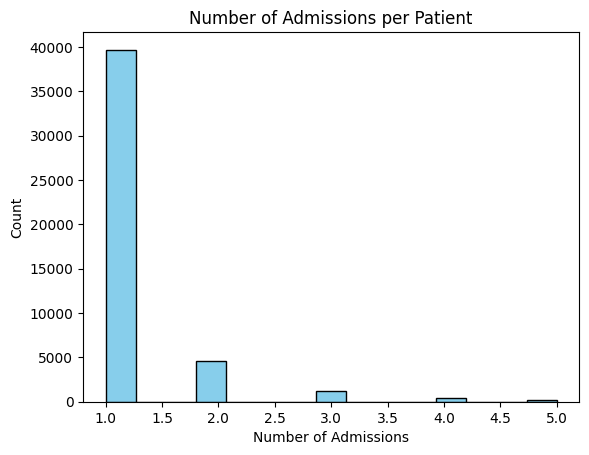

In [ ]:
results = admissions_per_patient.num_admissions[admissions_per_patient.num_admissions.between(admissions_per_patient.num_admissions.quantile(.00), admissions_per_patient.num_admissions.quantile(.99))]

plt.hist(results, bins=15, color='skyblue', edgecolor='black')
plt.title('Number of Admissions per Patient')
plt.xlabel('Number of Admissions')
plt.ylabel('Count')
plt.show()

From the statistics and histogram obtained above, we can infer that most patients are admitted to the ICU only once, with relatively few patients being admitted two or more times.

Outliers, such as the patient admitted 41 times, were omitted to enhance the clarity and readability of the diagram.

Other relevant features to analyze include those that describe the individuals, such as gender or age:

In [ ]:
%%bigquery patients --project $PROJECT_ID
SELECT *
FROM MIMIC.PATIENTS

Query is running:   0%|          |

Downloading:   0%|          |

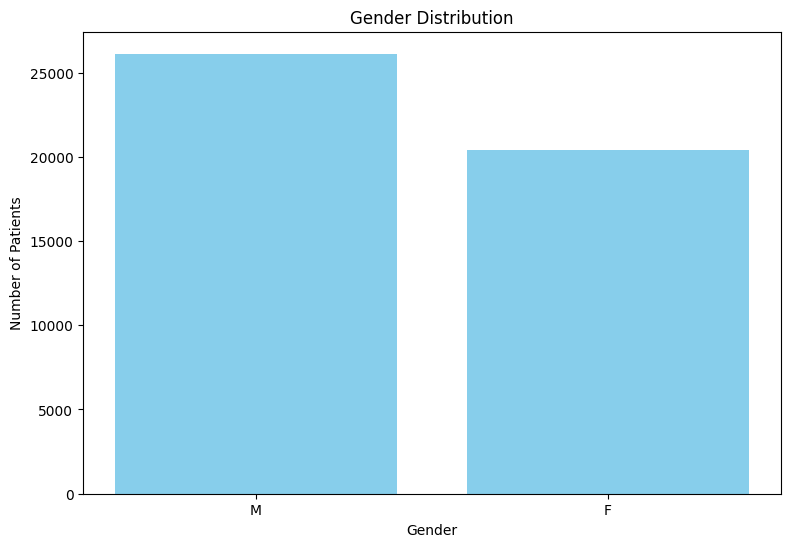

In [ ]:
#gender distribution
gender_counts = patients['GENDER'].value_counts()
plt.figure(figsize=(9, 6))
plt.bar(gender_counts.index, gender_counts.values, color='skyblue')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Number of Patients')
plt.show()

From the distribution above, we can see that more male patients have been admitted to the ICU than female patients. However, the difference is not significant, indicating a fairly balanced distribution.

In [ ]:
%%bigquery inc_age --project $PROJECT_ID
SELECT DISTINCT p.SUBJECT_ID, GREATEST(0,CAST(TIMESTAMP_DIFF(ADMITTIME, DOB, DAY)/365 - 0.5 AS INTEGER)) AS AGE
FROM MIMIC.ADMISSIONS a
INNER JOIN MIMIC.PATIENTS p
ON p.SUBJECT_ID = a.SUBJECT_ID
ORDER BY p.SUBJECT_ID

Query is running:   0%|          |

Downloading:   0%|          |

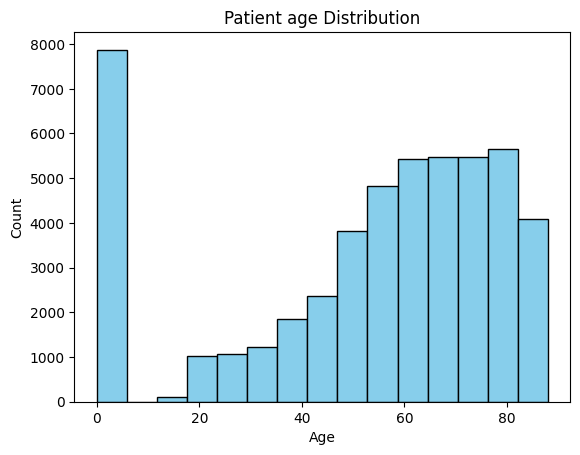

In [ ]:
#age distribution
results = inc_age.AGE[inc_age.AGE.between(inc_age.AGE.quantile(.0), inc_age.AGE.quantile(.95))]

plt.hist(results, bins=15, color='skyblue', edgecolor='black')
plt.title('Patient age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

From the histogram above, we can infer that most of the admitted patients were of more advanced age, which is to be expected. However, we can also observe a peak in admissions at very young ages, suggesting that young children are also susceptible to conditions that require ICU care.

Another highly relevant piece of information that we can infer from this dataset is the mortality rate with respect to ICU admissions.

In [ ]:
%%bigquery admissions --project $PROJECT_ID
SELECT *
FROM MIMIC.ADMISSIONS

Query is running:   0%|          |

Downloading:   0%|          |

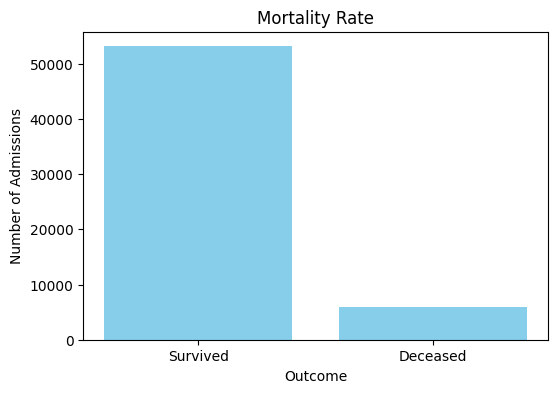

In [ ]:
# Mortality Rate
mortality = admissions['HOSPITAL_EXPIRE_FLAG'].value_counts()
plt.figure(figsize=(6, 4))
plt.bar(mortality.index, mortality.values, color='skyblue')
plt.xticks([0, 1], ['Survived', 'Deceased'])
plt.title('Mortality Rate')
plt.xlabel('Outcome')
plt.ylabel('Number of Admissions')
plt.show()

Here we can see that only about $\frac{1}{6}$th of the admissions ended with the death of a patient.

This analysis is particularly important for our examination of the length of stay. Including admissions where a patient died during their stay would skew the results, as their length of stay does not accurately reflect the typical duration for patients with the same diagnosis who survive (it may have been longer if the patient hadn't died).

Besides information about the patients and their admissions, it is important to gather data on the different diagnoses registered and their dependence on patient characteristics, such as age and gender. These characteristics may influence their susceptibility to certain diseases.

In [ ]:
%%bigquery diagnoses --project $PROJECT_ID
SELECT d_icd.SHORT_TITLE AS disease, COUNT(DISTINCT di.HADM_ID) AS num_admissions
FROM MIMIC.DIAGNOSES_ICD di
JOIN MIMIC.D_ICD_DIAGNOSES d_icd
ON di.ICD9_CODE = d_icd.ICD9_CODE
GROUP BY d_icd.SHORT_TITLE
ORDER BY num_admissions DESC

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
diagnoses.size

13540

There are 13,540 distinct diagnoses registered in this dataset.

We want to focus on the most frequently occurring diagnoses, so we can plot the number of admissions for each diagnosis.

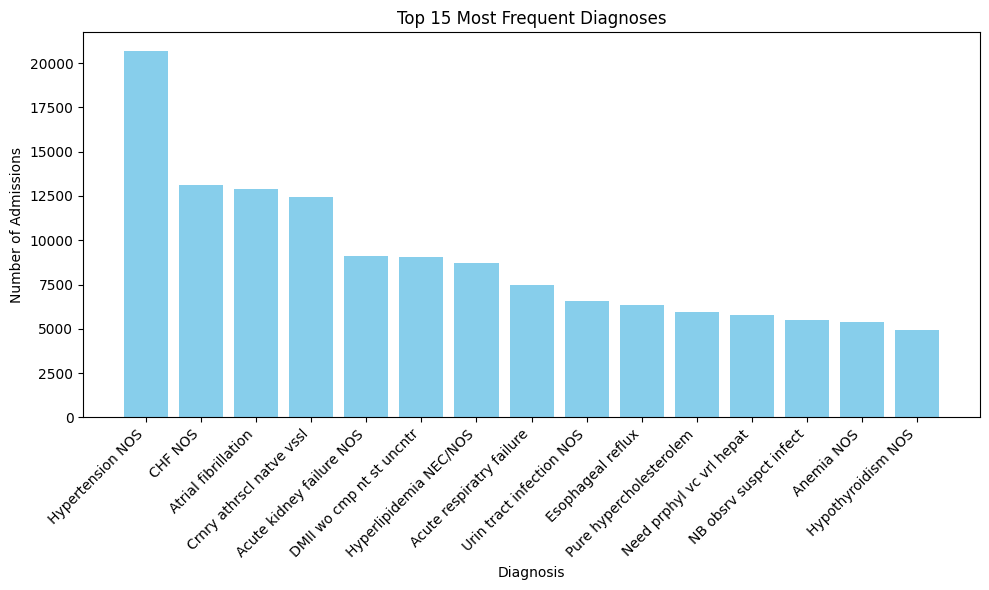

In [ ]:
#top n diagnosis
top_n = 15
top_diagnoses = diagnoses.head(top_n)

plt.figure(figsize=(10, 6))
plt.bar(top_diagnoses['disease'], top_diagnoses['num_admissions'], color='skyblue')
plt.title(f'Top {top_n} Most Frequent Diagnoses')
plt.xlabel('Diagnosis')
plt.ylabel('Number of Admissions')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

From the distribution above, we can observe that the first four diagnoses are related, as they all involve cardiovascular problems. Therefore, we will primarily focus on these four diseases moving forward.

This approach is particularly beneficial for the machine learning section, as using diseases that are not only common but also share common features can enhance our analysis.

Now that we have narrowed our focus down to this subset of diseases, we can analyze them with respect to the types of patients they are typically found in.

Specifically, we can examine how the incidence of these diseases varies with age, gender and ethnicity, as many illnesses are known to be influenced by these characteristics.

In [ ]:
%%bigquery subset_age --project $PROJECT_ID
WITH top_diseases AS (
  SELECT di.ICD9_CODE, COUNT(DISTINCT di.HADM_ID) AS num_admissions
  FROM MIMIC.DIAGNOSES_ICD di
  JOIN MIMIC.D_ICD_DIAGNOSES d_icd
  ON di.ICD9_CODE = d_icd.ICD9_CODE
  GROUP BY di.ICD9_CODE
  ORDER BY num_admissions DESC
  LIMIT 4
)
SELECT DISTINCT p.SUBJECT_ID, GREATEST(0, CAST(TIMESTAMP_DIFF(a.ADMITTIME, p.DOB, DAY) / 365 - 0.5 AS INTEGER)) AS AGE
FROM top_diseases td
JOIN MIMIC.DIAGNOSES_ICD di
ON td.ICD9_CODE = di.ICD9_CODE
JOIN MIMIC.PATIENTS p
ON di.SUBJECT_ID = p.SUBJECT_ID
JOIN MIMIC.ADMISSIONS a
ON p.SUBJECT_ID = a.SUBJECT_ID
ORDER BY p.SUBJECT_ID;

Query is running:   0%|          |

Downloading:   0%|          |

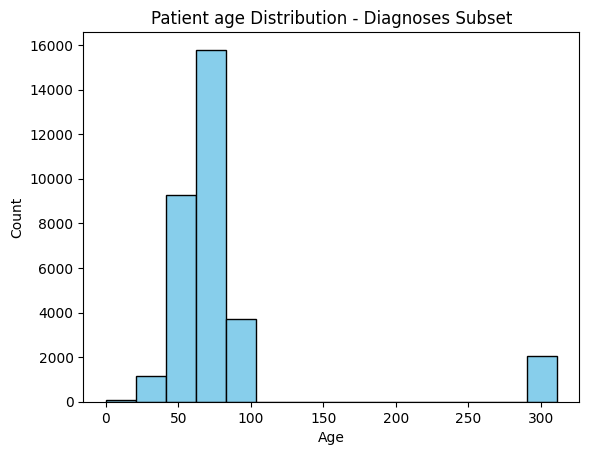

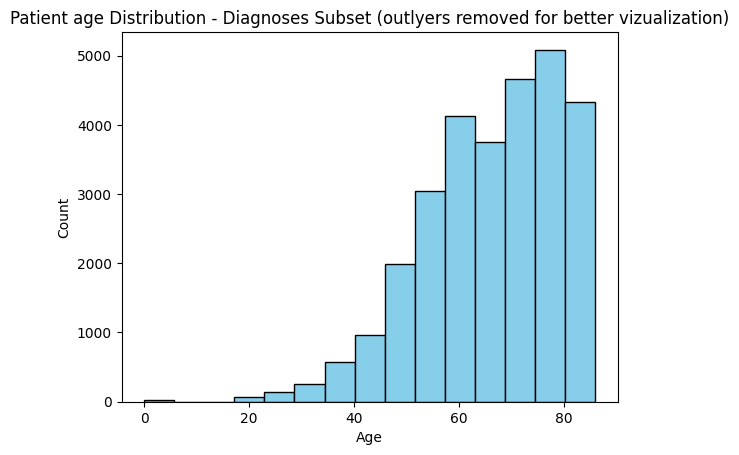

In [ ]:
#age distribution
#results1 = subset_age.AGE[subset_age.AGE.between(subset_age.AGE.quantile(.00), subset_age.AGE.quantile(.90))]
results1 = subset_age.AGE

results2 = subset_age.AGE[subset_age.AGE.between(subset_age.AGE.quantile(.00), subset_age.AGE.quantile(.90))]

plt.hist(results1, bins=15, color='skyblue', edgecolor='black')
plt.title('Patient age Distribution - Diagnoses Subset')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

plt.hist(results2, bins=15, color='skyblue', edgecolor='black')
plt.title('Patient age Distribution - Diagnoses Subset (outlyers removed for better vizualization)')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


From the histograms above, we can see that some ages simply don't make sense, likely due to transformations made to anonymize the data. However, visualizing the data without these entries, we can see that the majority of patients with the subset of diseases we have chosen are above 40 years old, with the most prevalent ages being between 60 and 80.

Now we can visualize the distribution of sex in the 4 diagnoses we chose to study.

In [ ]:
%%bigquery subset_gender --project $PROJECT_ID
WITH top_diseases AS (
  SELECT di.ICD9_CODE, d_icd.SHORT_TITLE, COUNT(DISTINCT di.HADM_ID) AS num_admissions
  FROM MIMIC.DIAGNOSES_ICD di
  JOIN MIMIC.D_ICD_DIAGNOSES d_icd
  ON di.ICD9_CODE = d_icd.ICD9_CODE
  GROUP BY di.ICD9_CODE, d_icd.SHORT_TITLE
  ORDER BY num_admissions DESC
  LIMIT 4
)
SELECT DISTINCT td.SHORT_TITLE, p.GENDER, COUNT(*) AS freq
FROM top_diseases td
JOIN MIMIC.DIAGNOSES_ICD di
ON td.ICD9_CODE = di.ICD9_CODE
JOIN MIMIC.PATIENTS p
ON di.SUBJECT_ID = p.SUBJECT_ID
GROUP BY td.SHORT_TITLE, p.GENDER
ORDER BY freq DESC;

Query is running:   0%|          |

Downloading:   0%|          |

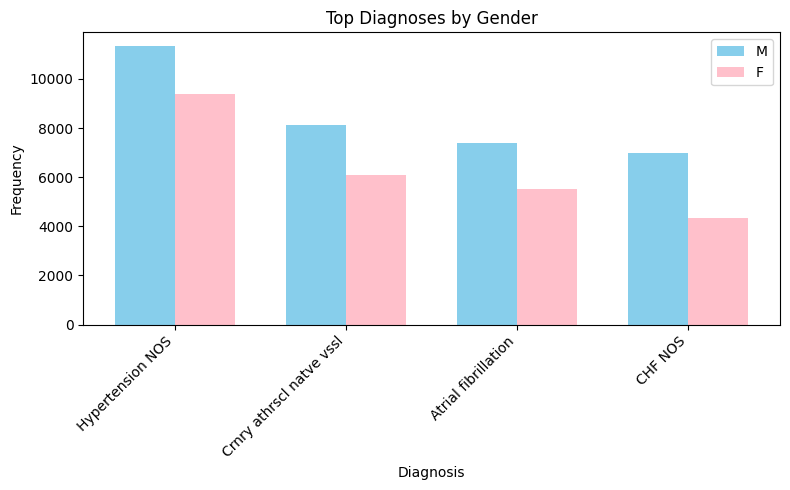

In [ ]:
#gender distribution
male_data = subset_gender[subset_gender['GENDER'] == 'M']
female_data = subset_gender[subset_gender['GENDER'] == 'F']

bar_width = 0.35
index = range(len(male_data))

plt.figure(figsize=(8, 5))
plt.bar(index, male_data['freq'], bar_width, label='M', color='skyblue')
plt.bar([p + bar_width for p in index], female_data['freq'], bar_width, label='F', color='pink')

plt.xlabel('Diagnosis')
plt.ylabel('Frequency')
plt.title('Top Diagnoses by Gender')
plt.xticks([p + bar_width/2 for p in index], male_data['SHORT_TITLE'], rotation=45, ha='right')
plt.legend()

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

This distribution shows that, while the difference is not very large, men tend to have a slightly higher tendency to be admitted for cardiovascular diseases compared to women. This observation is supported by research indicating that men are generally more prone to developing these types of problems than women.

Now we can repeat the same procedure for the ethnicites.

In [ ]:
%%bigquery subset_ethnicity --project $PROJECT_ID
WITH top_diseases AS (
  SELECT di.ICD9_CODE, d_icd.SHORT_TITLE, COUNT(DISTINCT di.HADM_ID) AS num_admissions
  FROM MIMIC.DIAGNOSES_ICD di
  JOIN MIMIC.D_ICD_DIAGNOSES d_icd ON di.ICD9_CODE = d_icd.ICD9_CODE
  GROUP BY di.ICD9_CODE, d_icd.SHORT_TITLE
  ORDER BY num_admissions DESC
  LIMIT 4
), disease_ethnicity_counts AS (
  SELECT a.SUBJECT_ID, a.ETHNICITY, di.ICD9_CODE, td.SHORT_TITLE
  FROM top_diseases td
  JOIN MIMIC.DIAGNOSES_ICD di ON td.ICD9_CODE = di.ICD9_CODE
  JOIN MIMIC.ADMISSIONS a ON di.SUBJECT_ID = a.SUBJECT_ID
)
SELECT de.ICD9_CODE,
       de.SHORT_TITLE,
       de.ETHNICITY,
       COUNT(DISTINCT de.SUBJECT_ID) AS num_patients
FROM disease_ethnicity_counts de
GROUP BY de.ICD9_CODE, de.ETHNICITY, de.SHORT_TITLE
ORDER BY de.ICD9_CODE, num_patients DESC;

Query is running:   0%|          |

Downloading:   0%|          |

<ipython-input-22-3a893e200887>:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = plt.cm.get_cmap('tab10', num_ethnicities)  # Adjust color palette as needed


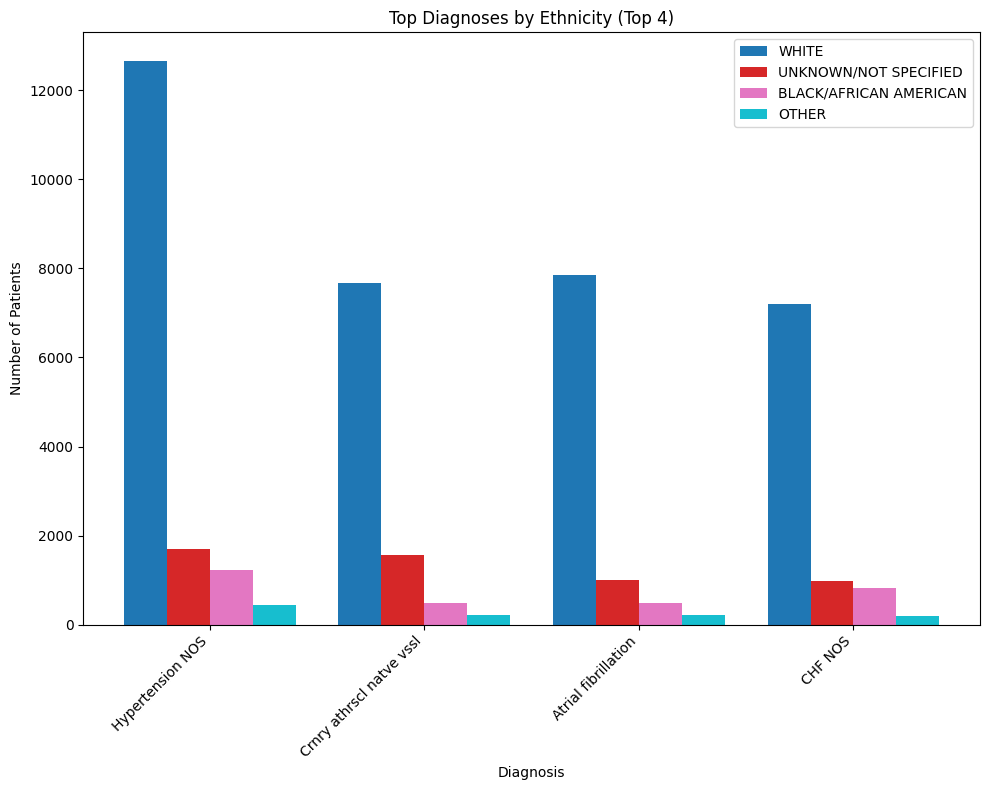

In [ ]:
import matplotlib.pyplot as plt



# Separate data for each ethnicity
ethnicity_data = {}
for ethnicity in subset_ethnicity['ETHNICITY'].unique():
    ethnicity_data[ethnicity] = subset_ethnicity[subset_ethnicity['ETHNICITY'] == ethnicity]

# Get unique diseases (ICD9_CODE) across all ethnicities
unique_diseases = subset_ethnicity['SHORT_TITLE'].unique()

# Calculate total number of patients per ethnicity
ethnicity_counts = subset_ethnicity.groupby('ETHNICITY')['num_patients'].sum()
# Sort by total number of patients and get the top 3 most common ethnicities
top_ethnicities = ethnicity_counts.nlargest(4).index.tolist()

# Prepare plotting for the top ethnicities
bar_width = 0.2
num_ethnicities = len(top_ethnicities)
index = range(len(unique_diseases))

plt.figure(figsize=(10, 8))

# Plot bars for each of the top ethnicities
color_palette = plt.cm.get_cmap('tab10', num_ethnicities)
legend_labels = []
for i, ethnicity in enumerate(top_ethnicities):
    data = ethnicity_data[ethnicity]

    # Match data to unique diseases index
    matched_data = data[data['SHORT_TITLE'].isin(unique_diseases)]

    # Ensure matched_data aligns with index by reindexing or mapping to ensure consistent data structure across ethnicities
    matched_data = matched_data.set_index('SHORT_TITLE').reindex(unique_diseases).reset_index()

    # Replace NaN values with 0
    matched_data['num_patients'].fillna(0, inplace=True)

    # Plot only if there are valid numeric values
    if not matched_data['num_patients'].isnull().all():
        plt.bar([p + i * bar_width for p in index], matched_data['num_patients'], bar_width, label=ethnicity, color=color_palette(i))
        legend_labels.append(ethnicity)

# Customize plot appearance
plt.xlabel('Diagnosis')
plt.ylabel('Number of Patients')
plt.title('Top Diagnoses by Ethnicity (Top 4)')
plt.xticks([p + bar_width * (num_ethnicities - 1) / 2 for p in index], unique_diseases, rotation=45, ha='right')
plt.legend(legend_labels)

plt.tight_layout()
plt.show()


Here, we considered only the four most common ethnicities due to the large number of ethnic categories, many of which had very low counts that were not significant. From this distribution, we observe that the vast majority of patients admitted with these four diagnoses were white. However, this observation may be influenced by the majority white population in the dataset's location, and thus may not indicate substantial differences in disease incidence based on ethnicity. This analysis would be more informative if there were a more balanced distribution of ethnicities in the studied location.

The MIMIC-III dataset also includes information about the items administered during each ICU admission. These items can include various types such as medications, exams, or exam results.

We can analyze how these items evolve over the course of a patient's ICU admission, using them as indicators of possible length of stay. For instance, normal exam results typically indicate patient recovery and readiness to leave the ICU.

For this analysis, we can gather data on the three most common items administered during admissions related to the selected subset of diagnoses. We will then examine how these items vary over time for a given patient.

In [ ]:
%%bigquery items --project $PROJECT_ID

WITH top_diseases AS (
  SELECT di.ICD9_CODE, d_icd.SHORT_TITLE, COUNT(DISTINCT di.HADM_ID) AS num_admissions
  FROM `MIMIC.DIAGNOSES_ICD` di
  JOIN `MIMIC.D_ICD_DIAGNOSES` d_icd
  ON di.ICD9_CODE = d_icd.ICD9_CODE
  GROUP BY di.ICD9_CODE, d_icd.SHORT_TITLE
  ORDER BY num_admissions DESC
  LIMIT 4
),

top_items AS (
  SELECT DISTINCT it.ITEMID, it.LABEL, COUNT(*) AS freq
  FROM top_diseases td
  JOIN `MIMIC.DIAGNOSES_ICD` di
  ON td.ICD9_CODE = di.ICD9_CODE
  JOIN `MIMIC.PATIENTS` p
  ON di.SUBJECT_ID = p.SUBJECT_ID
  JOIN `MIMIC.CHARTEVENTS` ch
  ON di.HADM_ID = ch.HADM_ID
  JOIN `MIMIC.D_ITEMS` it
  ON ch.itemid = it.ITEMID
  WHERE ch.VALUEUOM IS NOT NULL  -- Filter out items with NULL values
  AND p.SUBJECT_ID IN (
    SELECT DISTINCT SUBJECT_ID
    FROM `MIMIC.DIAGNOSES_ICD` di_inner
    WHERE di_inner.ICD9_CODE IN (SELECT ICD9_CODE FROM top_diseases)
    LIMIT 1  -- Limit to any one patient who has one of the top diseases
  )
  GROUP BY it.ITEMID, it.LABEL
  ORDER BY freq DESC
  LIMIT 4
),

patient_items AS (
  SELECT ch.ITEMID, ch.CHARTTIME, ch.VALUENUM, ch.SUBJECT_ID, it.LABEL
  FROM `MIMIC.CHARTEVENTS` ch
  JOIN top_items ti
  ON ch.ITEMID = ti.ITEMID
  JOIN `MIMIC.D_ITEMS` it
  ON ch.itemid = it.ITEMID
  WHERE ch.SUBJECT_ID IN (
    SELECT DISTINCT SUBJECT_ID
    FROM `MIMIC.DIAGNOSES_ICD` di_inner
    WHERE di_inner.ICD9_CODE IN (SELECT ICD9_CODE FROM top_diseases)
    ORDER BY SUBJECT_ID
    LIMIT 1  -- Limit to any one patient who has one of the top diseases
  )
)

SELECT *
FROM patient_items
ORDER BY SUBJECT_ID, CHARTTIME;


Query is running:   0%|          |

Downloading:   0%|          |

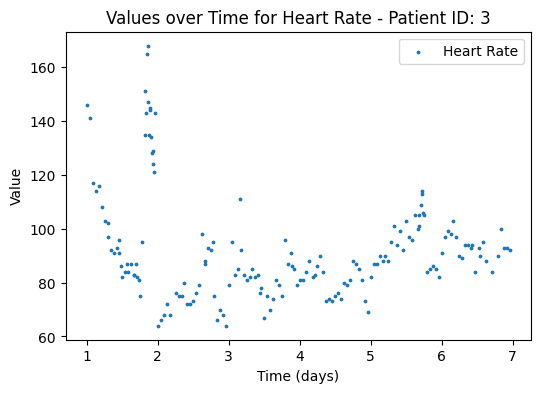

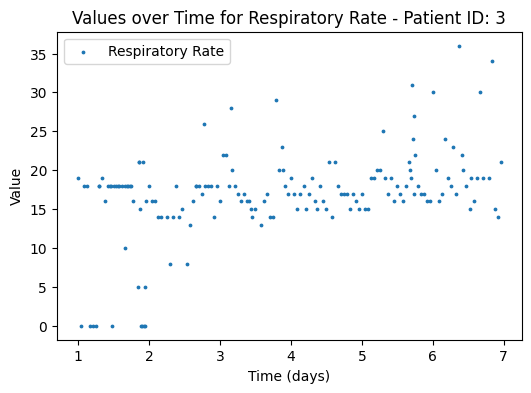

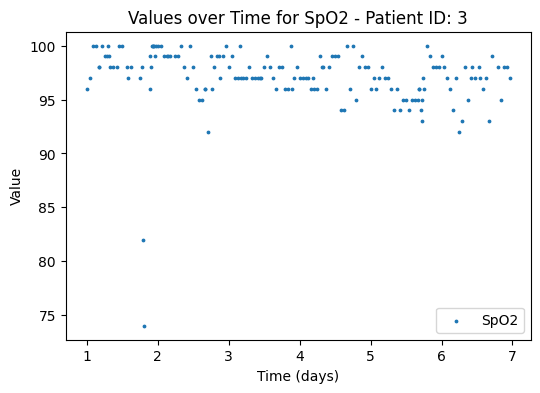

In [ ]:
# Calculate days since the first CHARTTIME (considering it as day 1)
items['DAY_TIME'] = (items['CHARTTIME'] - items['CHARTTIME'].min()).dt.days + 1 + (items['CHARTTIME'].dt.hour + items['CHARTTIME'].dt.minute / 60) / 24

# Get unique item labels
item_labels = items['LABEL'].unique()
patient = items['SUBJECT_ID'].unique()[0]

# Create a separate plot for each item
for label in item_labels:
    if label != "calprevflg": # discard this one as it only denotes a flag signifying whether a given procedure has been done
      plt.figure(figsize=(6, 4))
      plt.title(f'Values over Time for {label} - Patient ID: {patient}')
      plt.xlabel('Time (days)')
      plt.ylabel('Value')

      # Filter data for the current item label
      item_data = items[items['LABEL'] == label]


      plt.scatter(item_data['DAY_TIME'], item_data['VALUENUM'], label=label, s=3)

      plt.legend()



      plt.show()

Looking at the graphs above, it is possible to infer that the first two days since admission for the patient with ID = 3 were potentially the most critical in terms of the patient's health. This inference is based on several observations: there was a dip in SpO2 (oxygen saturation) and Respiratory Rate values, with the latter even reaching 0, indicating a temporary inability to breathe. Additionally, the patient's heart rate was very elevated during these days, well above the normal range of 60 to 100 bpm for an average adult.

Finally, we will now focus primarily on the analysis surrounding the length of stay, which will be the main objective of the model we will be training. As mentioned before, only patients who survived their stay in the ICU will be considered for this analysis.

In [ ]:
%%bigquery live_icustays --project $PROJECT_ID
SELECT icu.*
FROM MIMIC.ICUSTAYS icu
JOIN MIMIC.PATIENTS p
ON p.SUBJECT_ID = icu.SUBJECT_ID
WHERE p.EXPIRE_FLAG = 0

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
%%bigquery live_icustays_subset --project $PROJECT_ID
WITH top_diseases AS (
  SELECT di.ICD9_CODE, d_icd.SHORT_TITLE, COUNT(DISTINCT di.HADM_ID) AS num_admissions
  FROM `MIMIC.DIAGNOSES_ICD` di
  JOIN `MIMIC.D_ICD_DIAGNOSES` d_icd
  ON di.ICD9_CODE = d_icd.ICD9_CODE
  GROUP BY di.ICD9_CODE, d_icd.SHORT_TITLE
  ORDER BY num_admissions DESC
  LIMIT 4
)
SELECT icu.*, di.ICD9_CODE
FROM MIMIC.ICUSTAYS icu
JOIN MIMIC.PATIENTS p
ON p.SUBJECT_ID = icu.SUBJECT_ID
JOIN MIMIC.DIAGNOSES_ICD di
ON di.HADM_ID = icu.HADM_ID
JOIN top_diseases td
ON di.ICD9_CODE = td.ICD9_CODE
WHERE p.EXPIRE_FLAG = 0;

Query is running:   0%|          |

Downloading:   0%|          |

We can now obtain the distribution of length of stay across all admissions and compare it to the distribution specifically for our disease subset.

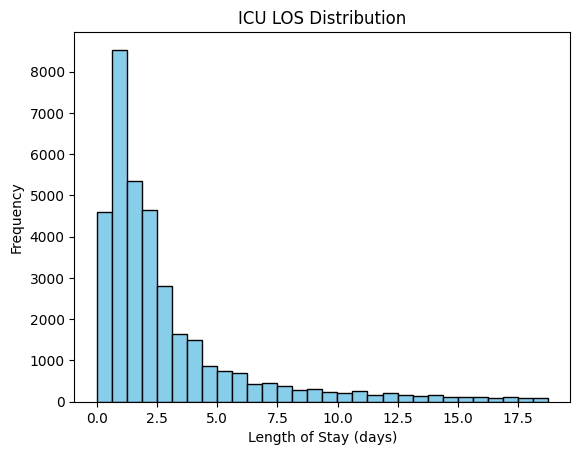

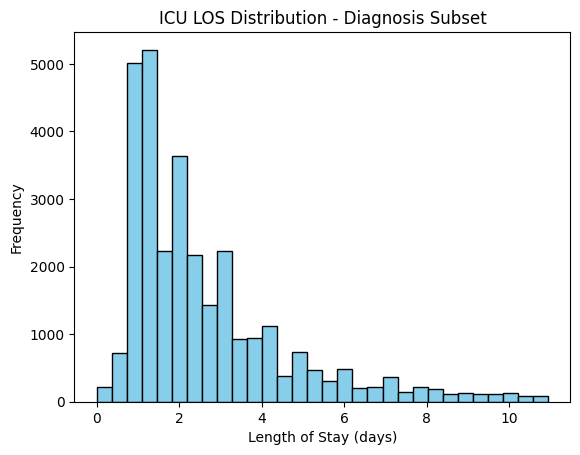

In [ ]:
results1 = live_icustays.LOS[live_icustays.LOS.between(live_icustays.LOS.quantile(.00), live_icustays.LOS.quantile(.95))]
results2 = live_icustays_subset.LOS[live_icustays_subset.LOS.between(live_icustays_subset.LOS.quantile(.00), live_icustays_subset.LOS.quantile(.95))]

plt.hist(results1, bins=30, color='skyblue', edgecolor='black')
plt.title('ICU LOS Distribution')
plt.xlabel('Length of Stay (days)')
plt.ylabel('Frequency')
plt.show()


plt.hist(results2, bins=30, color='skyblue', edgecolor='black')
plt.title('ICU LOS Distribution - Diagnosis Subset')
plt.xlabel('Length of Stay (days)')
plt.ylabel('Frequency')
plt.show()

Through the histograms above, we can see that the distribution of length of stay for the subset of diseases we chose is slightly skewed to the right. Despite the difference not being very significant, this skewness may indicate that these illnesses often require longer ICU stays, possibly suggesting that they are more serious compared to other conditions.

We will now carefully analyze the length of stay in relation to each disease in our subset using boxplots for visualization.

In [ ]:
%%bigquery subset_data --project $PROJECT_ID
WITH top_diseases AS (
    SELECT d_icd.SHORT_TITLE AS disease
    FROM MIMIC.DIAGNOSES_ICD di
    JOIN MIMIC.D_ICD_DIAGNOSES d_icd ON di.ICD9_CODE = d_icd.ICD9_CODE
    GROUP BY d_icd.SHORT_TITLE
    ORDER BY COUNT(DISTINCT di.SUBJECT_ID) DESC
    LIMIT 4
)

SELECT *
FROM MIMIC.ICUSTAYS icu
JOIN MIMIC.DIAGNOSES_ICD di ON icu.HADM_ID = di.HADM_ID
JOIN MIMIC.D_ICD_DIAGNOSES did ON di.ICD9_CODE = did.ICD9_CODE
JOIN MIMIC.PATIENTS p ON p.SUBJECT_ID = icu.SUBJECT_ID
JOIN top_diseases td ON did.SHORT_TITLE = td.disease
WHERE p.EXPIRE_FLAG = 0;

Query is running:   0%|          |

Downloading:   0%|          |

<ipython-input-30-2c6128fbcb45>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='disease', y='LOS', data=subset_data, showfliers=False, palette='Set1')


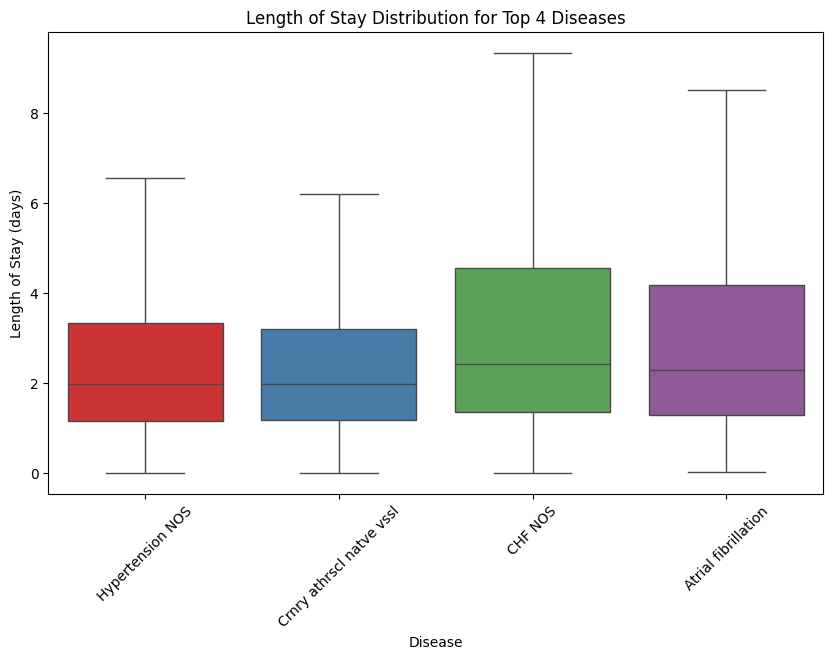

In [ ]:
# Create a box plot using Matplotlib
plt.figure(figsize=(10, 6))
sns.boxplot(x='disease', y='LOS', data=subset_data, showfliers=False, palette='Set1')
plt.title('Length of Stay Distribution for Top 4 Diseases')
plt.xlabel('Disease')
plt.ylabel('Length of Stay (days)')
plt.suptitle('')  # Remove default title
plt.xticks(rotation=45)
plt.show()


In the above diagram, we can observe that for each of the diseases in our subset, the meadian length of stay is around 2 days, which is above the median for all registered diseases. Additionally, we notice that Atrial Fibrillation and Congestive Heart Failure generally have longer lengths of stay compared to the other two diseases. This suggests that these conditions may require more time for recovery, or that their testing and treatment protocols are more extensive.

These results are also consistent with the length of stay (LOS) distribution histogram we observed earlier, where we noted a right skew compared to the overall LOS distribution.

We can also calculate the average length of stay for each of the diseases:

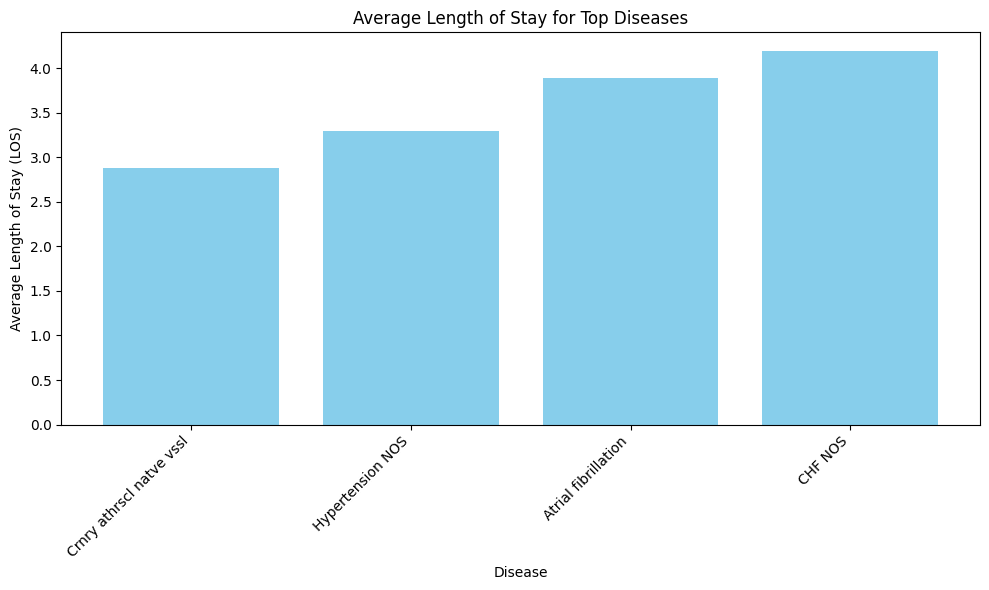

In [ ]:
# Calculate average LOS per disease
avg_los_per_disease = subset_data.groupby('disease')['LOS'].mean().reset_index()

# Sort by average LOS if needed
avg_los_per_disease = avg_los_per_disease.sort_values(by='LOS', ascending=True)

# Plotting with Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(avg_los_per_disease['disease'], avg_los_per_disease['LOS'], color='skyblue')
plt.xlabel('Disease')
plt.ylabel('Average Length of Stay (LOS)')
plt.title('Average Length of Stay for Top Diseases')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

These values are consistent with the previous boxplot results and once again highlight that these diseases have longer lengths of stay on average compared to the overall dataset average.

Additionally, we should note that the intersection of diseases is not null.

There are some patients who were diagnosed with multiple diseases during the same admission.

In [ ]:
live_icustays_subset[live_icustays_subset["HADM_ID"] == 143045]

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS,ICD9_CODE
9377,13,13,143045,263738,carevue,CCU,CSRU,57,14,2167-01-08 18:44:25+00:00,2167-01-12 10:43:31+00:00,3.666,41401
9378,13,13,143045,263738,carevue,CCU,CSRU,57,14,2167-01-08 18:44:25+00:00,2167-01-12 10:43:31+00:00,3.666,4019


It may interesting to investigate how the length of stay varies depending on the number of diseases diagnosed in each admission.

In [ ]:
%%bigquery icustays_data --project $PROJECT_ID
WITH top_diseases AS (
  SELECT di.ICD9_CODE, d_icd.SHORT_TITLE, COUNT(DISTINCT di.HADM_ID) AS num_admissions
  FROM MIMIC.DIAGNOSES_ICD di
  JOIN MIMIC.D_ICD_DIAGNOSES d_icd ON di.ICD9_CODE = d_icd.ICD9_CODE
  GROUP BY di.ICD9_CODE, d_icd.SHORT_TITLE
  ORDER BY num_admissions DESC
  LIMIT 4
)
SELECT icu.SUBJECT_ID, icu.HADM_ID, icu.LOS, COUNT(DISTINCT di.ICD9_CODE) AS num_diseases
FROM MIMIC.ICUSTAYS icu
JOIN MIMIC.PATIENTS p ON p.SUBJECT_ID = icu.SUBJECT_ID
JOIN MIMIC.DIAGNOSES_ICD di ON di.HADM_ID = icu.HADM_ID
JOIN top_diseases ts ON di.ICD9_CODE = ts.ICD9_CODE
WHERE p.EXPIRE_FLAG = 0
GROUP BY icu.SUBJECT_ID, icu.HADM_ID, icu.LOS;

Query is running:   0%|          |

Downloading:   0%|          |

<ipython-input-34-933bcdf195ba>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='num_diseases', y='LOS', data=icustays_data, showfliers=False, palette='Set1')


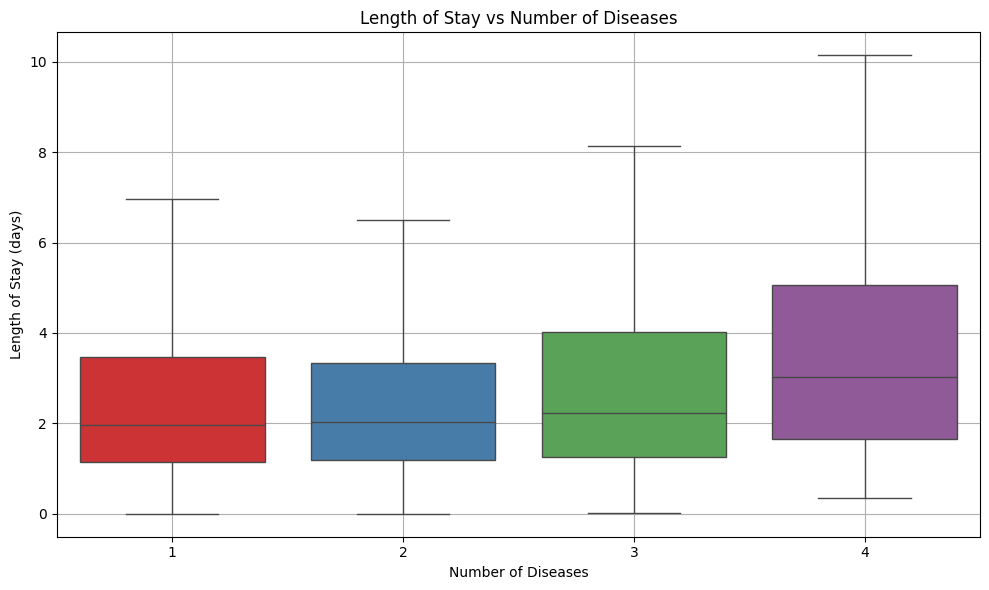

In [ ]:
# Plotting the relationship between Num_Diseases and LOS
plt.figure(figsize=(10, 6))
sns.boxplot(x='num_diseases', y='LOS', data=icustays_data, showfliers=False, palette='Set1')
plt.title('Length of Stay vs Number of Diseases')
plt.xlabel('Number of Diseases')
plt.ylabel('Length of Stay (days)')
plt.grid(True)
plt.tight_layout()
plt.show()

Although the difference is not very pronounced, there is a noticeable variation in the length of stay depending on the number of diseases diagnosed in each admission, particularly for cases involving 3 or 4 diseases. This suggests that patients admitted with more diseases may experience a longer recovery period, which aligns with expectations.

---
##Data Preprocessing for Model Training

As mentioned earlier, to train the length of stay prediction model, we will focus on the four most common diseases and only include admissions where the patient survived. Additionally, we will aggregate information based on admission ID rather than patient ID, as each patient can have multiple admissions.

Since this data alone would be insufficient for training a high-quality model, we will also incorporate information on some of the items administered during these admissions.

First, let's get the ICD9 code associated with each of these diseases:

In [ ]:
%%bigquery --project $PROJECT_ID
SELECT di.ICD9_CODE
FROM MIMIC.DIAGNOSES_ICD di
GROUP BY di.ICD9_CODE
ORDER BY COUNT(DISTINCT di.HADM_ID) DESC
LIMIT 4

Query is running:   0%|          |

Downloading:   0%|          |

,ICD9_CODE
0,4019
1,4280
2,42731
3,41401


Next, for each of these four diseases, we will gather relevant data related to patient admissions. This includes personal information such as age, gender, and ethnicity, which may be relevant to the length of stay. Additionally, we will collect information regarding items used during the admission and their values.

##All Four Diagnoses Combined

We will start by gathering information on the patient, the target value (length of stay, or LOS), and each item used throughout the admissions. For each item, we will collect the initial value (as it can indicate the severity of the illness upon admission) and the final value, which, together with the initial value, allows us to see the patient's progression over one day.

We restrict the considered items to the first day because our goal is to predict the length of stay soon after a patient is admitted. This means we will only have information about the initial items administered during their stay to make the prediction. While considering all items might provide better predictions, it would not be as realistic in practical applications, as we would not have all the information for the entire stay beforehand. This approach simulates the real-world scenario more accurately.

In [ ]:
%%bigquery df --project $PROJECT_ID

WITH main_data AS (
  SELECT DISTINCT
    ch.HADM_ID,
    ch.ITEMID,
    a.ADMISSION_TYPE,
    a.INSURANCE,
    a.RELIGION,
    a.MARITAL_STATUS,
    a.ETHNICITY,
    a.LANGUAGE,
    p.GENDER,
    ch.CHARTTIME,
    GREATEST(0, CAST(TIMESTAMP_DIFF(a.ADMITTIME, p.DOB, DAY) / 365 - 0.5 AS INTEGER)) AS AGE,
    COUNT(*) OVER (PARTITION BY ch.HADM_ID, ch.ITEMID) AS Total_Item_Values,
    FIRST_VALUE(
      CASE WHEN TIMESTAMP_DIFF(TIMESTAMP(ch.CHARTTIME), ADMITTIME, HOUR) <= 24 THEN VALUENUM ELSE NULL END
      IGNORE NULLS
    ) OVER (PARTITION BY ch.HADM_ID, ch.ITEMID ORDER BY ch.CHARTTIME ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS First_Item_Value,
    LAST_VALUE(
      CASE WHEN TIMESTAMP_DIFF(TIMESTAMP(ch.CHARTTIME), ADMITTIME, HOUR) <= 24 THEN VALUENUM ELSE NULL END
      IGNORE NULLS
    ) OVER (PARTITION BY ch.HADM_ID, ch.ITEMID ORDER BY CHARTTIME ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS Last_Item_Value,
    i.LOS
  FROM MIMIC.CHARTEVENTS ch
  JOIN MIMIC.DIAGNOSES_ICD di ON ch.HADM_ID = di.HADM_ID
  JOIN MIMIC.ADMISSIONS a ON ch.HADM_ID = a.HADM_ID
  JOIN MIMIC.PATIENTS p ON a.SUBJECT_ID = p.SUBJECT_ID
  JOIN MIMIC.ICUSTAYS i ON i.HADM_ID = ch.HADM_ID
  WHERE di.ICD9_CODE IN ('4019', '4280', '42731', '41401' )
  AND a.HOSPITAL_EXPIRE_FLAG = 0
  AND GREATEST(0, CAST(TIMESTAMP_DIFF(a.ADMITTIME, p.DOB, DAY) / 365 - 0.5 AS INTEGER)) <= 100
  AND SAFE_CAST(ch.VALUENUM AS NUMERIC) IS NOT NULL
),

item_restriction AS (
  SELECT ITEMID, COUNT(*) AS count, CORR(First_Item_Value, main_data.LOS) AS correlation
  FROM main_data
  GROUP BY ITEMID
  HAVING count >= 10000 AND ABS(correlation) >= 0.1
)

SELECT DISTINCT
  HADM_ID,
  ITEMID,
  ADMISSION_TYPE,
  INSURANCE,
  RELIGION,
  MARITAL_STATUS,
  ETHNICITY,
  LANGUAGE,
  GENDER,
  AGE,
  First_Item_Value,
  (First_Item_Value - Last_Item_Value) / Total_Item_Values as Item_Evolution,
  LOS
FROM main_data
JOIN item_restriction USING(ITEMID)

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df = df.dropna()
df

,HADM_ID,ITEMID,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,LANGUAGE,GENDER,AGE,First_Item_Value,Item_Evolution,LOS
4,159893,228396,EMERGENCY,Medicare,NOT SPECIFIED,MARRIED,HISPANIC OR LATINO,SPAN,M,63,3.0,0.000000,2.2588
6,148934,220059,EMERGENCY,Medicare,CATHOLIC,MARRIED,WHITE,ENGL,F,77,26.0,-0.080645,2.4825
10,177714,220061,ELECTIVE,Private,CATHOLIC,MARRIED,WHITE,ENGL,M,64,24.0,0.090909,1.3023
13,178692,220059,EMERGENCY,Private,CATHOLIC,SINGLE,WHITE,ENGL,M,59,49.0,0.007979,29.1490
17,197621,29,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,BLACK/AFRICAN AMERICAN,ENGL,M,45,-61.0,-0.166667,6.6471
...,...,...,...,...,...,...,...,...,...,...,...,...,...
567398,127337,1521,EMERGENCY,Medicare,JEWISH,WIDOWED,WHITE,ENGL,F,79,3.8,0.000000,4.6273
567399,164919,1521,EMERGENCY,Medicare,CATHOLIC,MARRIED,WHITE,ENGL,F,75,3.6,0.000000,2.1475
567402,119156,1521,EMERGENCY,Private,CATHOLIC,MARRIED,WHITE,ENGL,M,61,3.9,0.000000,6.2801
567403,182445,1521,ELECTIVE,Private,CATHOLIC,MARRIED,WHITE,ENGL,F,59,2.3,0.000000,2.1561


In [ ]:
df["ITEMID"].unique().size

116

To limit the number of considered items, we have chosen to include commonly used items—specifically those administered more than 10,000 times—that have a correlation with our target variable (length of stay) of 0.1 or greater. These values were selected based on our analysis, which showed they provide a good balance between correlation strength and data size.

Now, for each admission, we want to create a column for each item's first value and evolution measure, both of which may be indicators of length of stay. In order to do this, we will create 'dummy' columns that will contain the values of each item for each admission:

In [ ]:
prev_num_cols = df.shape[1]

first_value_dummies = pd.get_dummies(df['ITEMID'], prefix='First_Item_Value')
item_evolution_dummies = pd.get_dummies(df['ITEMID'], prefix='Item_Evolution')

df = pd.concat([df, first_value_dummies], axis=1)
df = pd.concat([df, item_evolution_dummies], axis=1)

for i,column in enumerate(df.columns):
  if i > ((df.shape[1] - prev_num_cols) /2 + prev_num_cols):
    df[column] *= df["Item_Evolution"]
  elif i > prev_num_cols:
    df[column] *= df["First_Item_Value"]

df = df.replace({True: 1, False: 0})

In [ ]:
df

,HADM_ID,ITEMID,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,LANGUAGE,GENDER,AGE,...,Item_Evolution_227565,Item_Evolution_228004,Item_Evolution_228096,Item_Evolution_228299,Item_Evolution_228395,Item_Evolution_228396,Item_Evolution_228409,Item_Evolution_228410,Item_Evolution_228411,Item_Evolution_228412
4,159893,228396,EMERGENCY,Medicare,NOT SPECIFIED,MARRIED,HISPANIC OR LATINO,SPAN,M,63,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,148934,220059,EMERGENCY,Medicare,CATHOLIC,MARRIED,WHITE,ENGL,F,77,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
10,177714,220061,ELECTIVE,Private,CATHOLIC,MARRIED,WHITE,ENGL,M,64,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,178692,220059,EMERGENCY,Private,CATHOLIC,SINGLE,WHITE,ENGL,M,59,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,197621,29,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,BLACK/AFRICAN AMERICAN,ENGL,M,45,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567398,127337,1521,EMERGENCY,Medicare,JEWISH,WIDOWED,WHITE,ENGL,F,79,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
567399,164919,1521,EMERGENCY,Medicare,CATHOLIC,MARRIED,WHITE,ENGL,F,75,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
567402,119156,1521,EMERGENCY,Private,CATHOLIC,MARRIED,WHITE,ENGL,M,61,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
567403,182445,1521,ELECTIVE,Private,CATHOLIC,MARRIED,WHITE,ENGL,F,59,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We kept items that weren't recorded at value 0 for two reasons:



1.   The models we want to train can't handle NaN values
2.   We don't want to have to discard every row that doesn't contain every item, as that would significantly reduce our data size, and affect our results

Next, we want to aggregate the rows by admission and select the maximum value of the from the Initial_Item_Value column corresponding to that admission, as, like we said, 0 is used as a placeholder and we want the actual values registered.



In [ ]:
cols = [col for col in df.columns if col != 'HADM_ID']
df = df.groupby('HADM_ID')

df = df[cols].agg(lambda x: max(list(set(x)))).reset_index()

df

,HADM_ID,ITEMID,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,LANGUAGE,GENDER,AGE,...,Item_Evolution_227565,Item_Evolution_228004,Item_Evolution_228096,Item_Evolution_228299,Item_Evolution_228395,Item_Evolution_228396,Item_Evolution_228409,Item_Evolution_228410,Item_Evolution_228411,Item_Evolution_228412
0,100003,227456,EMERGENCY,Private,NOT SPECIFIED,SINGLE,WHITE,ENGL,M,59,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,100018,227565,ELECTIVE,Private,PROTESTANT QUAKER,MARRIED,WHITE,ENGL,M,55,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,100020,227346,EMERGENCY,Private,CATHOLIC,MARRIED,WHITE,ENGL,M,58,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,100024,228299,ELECTIVE,Medicare,NOT SPECIFIED,MARRIED,UNKNOWN/NOT SPECIFIED,ENGL,M,71,...,-0.0,-0.0,0.111111,0.055556,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
4,100028,228096,EMERGENCY,Medicare,CATHOLIC,SINGLE,WHITE,ENGL,F,72,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14424,199933,228096,EMERGENCY,Private,NOT SPECIFIED,MARRIED,WHITE,ENGL,F,62,...,-0.0,-0.0,0.000000,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
14425,199952,779,EMERGENCY,Private,NOT SPECIFIED,MARRIED,WHITE,ITAL,M,84,...,-0.0,-0.0,-0.000000,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
14426,199956,224828,EMERGENCY,Medicare,CATHOLIC,SINGLE,WHITE,ENGL,F,77,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
14427,199967,228299,EMERGENCY,Medicare,NOT SPECIFIED,SINGLE,WHITE,ENGL,F,82,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


We now drop columns that aren't relevant to our model training, such as `HADM_ID` and `ITEMID`. Additionally, we remove columns like `LANGUAGE` and `ETHNICITY`. Although potentially relevant, these columns contain too many categories, which would add a substantial number of columns to our dataframe, likely outweighing the marginal improvement they might bring to the model results.

In [ ]:
#colums that are just residuals of the processing and now are of no use
df = df.drop(columns=['HADM_ID', 	'ITEMID', 'First_Item_Value', 'Item_Evolution', 'LANGUAGE', 'ETHNICITY', 'RELIGION'])


Here we also filter the items further, keeping only those that appear in at least 10% of the admissions. This ensures we don't include items where nearly all entries are zero, indicating they were not administered in most admissions. This step helps focus on more commonly relevant items and reduces the sparsity of our data.

In [ ]:
threshold = 0.95

# Iterate through the columns and drop those that exceed the threshold of zeros
for col in df.select_dtypes(include='number').columns:
    zero_percentage = (df[col] == 0.0).mean()
    if zero_percentage > threshold:
        df.drop(columns=[col], inplace=True)

df

,ADMISSION_TYPE,INSURANCE,MARITAL_STATUS,GENDER,AGE,LOS,First_Item_Value_87,First_Item_Value_113,First_Item_Value_198,First_Item_Value_211,...,Item_Evolution_224058,Item_Evolution_224685,Item_Evolution_224687,Item_Evolution_224690,Item_Evolution_224696,Item_Evolution_224697,Item_Evolution_224828,Item_Evolution_225668,Item_Evolution_227346,Item_Evolution_227464
0,EMERGENCY,Private,SINGLE,M,59,1.9425,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,0.000000
1,ELECTIVE,Private,MARRIED,M,55,3.9222,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.020000,0.000000,0.000000,0.088889,0.111111,0.000000,0.0,0.000000
2,EMERGENCY,Private,MARRIED,M,58,1.1011,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,ELECTIVE,Medicare,MARRIED,M,71,1.0799,0.0,0.0,0.0,0.0,...,0.333333,17.416667,0.016667,-0.000000,-0.000000,-0.000000,0.222222,-0.000000,-0.0,0.016667
4,EMERGENCY,Medicare,SINGLE,F,72,2.0321,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14424,EMERGENCY,Private,MARRIED,F,62,1.2030,-0.0,-0.0,-0.0,-0.0,...,0.333333,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,5.0,-0.000000
14425,EMERGENCY,Private,MARRIED,M,84,15.0094,16.0,0.0,15.0,69.0,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.0,-0.000000
14426,EMERGENCY,Medicare,SINGLE,F,77,1.5428,19.0,0.0,15.0,81.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
14427,EMERGENCY,Medicare,SINGLE,F,82,1.9588,0.0,0.0,0.0,0.0,...,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


Finally, before applying the intended models, we first need to encode all categorical values into numerical values, drop any null values, and divide the data into training and test sets:

In [ ]:
categorical_cols = df.select_dtypes(include=['object']).columns
numeric_cols = df.select_dtypes(include=['number']).columns.drop('LOS')

# One-hot encode categorical features with 0s and 1s
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

df = df.replace({True: 1, False: 0})

# Apply MinMaxScaler to numeric columns excluding the target variable
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])


df[numeric_cols] = df[numeric_cols].astype(float)

# Define the target and features
target = df['LOS']
features = df.drop(columns=['LOS'])

X = features
y = target

y = y.clip(upper=25)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

df

,AGE,LOS,First_Item_Value_87,First_Item_Value_113,First_Item_Value_198,First_Item_Value_211,First_Item_Value_431,First_Item_Value_492,First_Item_Value_543,First_Item_Value_578,...,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Self Pay,MARITAL_STATUS_LIFE PARTNER,MARITAL_STATUS_MARRIED,MARITAL_STATUS_SEPARATED,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_WIDOWED,GENDER_M
0,0.589041,1.9425,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,1,0,0,1
1,0.534247,3.9222,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0,1,0,0,1,0,0,0,0,1
2,0.575342,1.1011,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0,1,0,0,1,0,0,0,0,1
3,0.753425,1.0799,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,1,0,0,0,1,0,0,0,0,1
4,0.767123,2.0321,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14424,0.630137,1.2030,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0,1,0,0,1,0,0,0,0,0
14425,0.931507,15.0094,0.695652,0.0,1.0,0.398844,0.0,0.0,0.0,0.0,...,0,1,0,0,1,0,0,0,0,1
14426,0.835616,1.5428,0.826087,0.0,1.0,0.468208,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,0,0,0
14427,0.904110,1.9588,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,0,0,0


We can now finally train our models using this dataframe.

We will be using 3 different frameworks:

1.   **Normal Sequential Execution** (ex: using sklearn directly)
2.   **Dask**
3.   **Pyspark**


And we will testing the following models in each of the frameworks:

1. **Linear Regression**
2. **XGBoost**
3. **Random Forest**


We are exclusively using regression models because our target variable is continuous, which defines this problem as a regression task. While converting the target values into categorical variables and applying models suitable for categorical targets is an option, we deemed the regression approach more appropriate for real-life predictions in this context.


###Linear Regression:

####Sequential Execution

In [ ]:
from sklearn.linear_model import LinearRegression

lr_model_sk = LinearRegression()



In [ ]:
%%time
lr_model_sk.fit(X_train, y_train)

CPU times: user 141 ms, sys: 12.4 ms, total: 154 ms
Wall time: 103 ms


LinearRegression()

In [ ]:
%%time
predictions = lr_model_sk.predict(X_test)

CPU times: user 7.58 ms, sys: 920 µs, total: 8.5 ms
Wall time: 8.47 ms


In [ ]:

print('Mean Absolute Error:', mean_absolute_error(y_test, predictions))
print('Mean Squared Error:', mean_squared_error(y_test, predictions))
print('R-squared:', r2_score(y_test, predictions))

Mean Absolute Error: 2.5595230848663295
Mean Squared Error: 23.009494467994177
R-squared: 0.17820227940664857


###Dask

In [ ]:
from dask_ml.linear_model import LinearRegression
from dask_ml.metrics import mean_squared_error
from dask_ml.model_selection import train_test_split as train_test_split_dask
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster



X_ = dd.from_pandas(X, npartitions=3)
y_  = dd.from_pandas(y, npartitions=3)

X_d = X_.to_dask_array(lengths=True)
y_d = y_.to_dask_array(lengths=True)

X_train, X_test, y_train, y_test = train_test_split_dask(X_d, y_d, test_size=0.2, random_state=42)

In [ ]:
%%time
lr_model_dk = LinearRegression()



lr_model_dk.fit(X_train, y_train)

CPU times: user 1min 53s, sys: 1min 4s, total: 2min 58s
Wall time: 1min 57s


LinearRegression()

In [ ]:
%%time

predictions = lr_model_dk.predict(X_test)

CPU times: user 6.43 ms, sys: 113 µs, total: 6.54 ms
Wall time: 10.1 ms


In [ ]:
print('Mean Absolute Error:', mean_absolute_error(y_test, predictions))
print('Mean Squared Error:', mean_squared_error(y_test, predictions))
print('R-squared:', r2_score(y_test, predictions))

Mean Absolute Error: 2.356699157085927
Mean Squared Error: 14.512340717540601
R-squared: 0.24725885493358446


### PySpark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
import re
from pyspark.ml.evaluation import RegressionEvaluator

spark = SparkSession.builder.appName("PySparkRegressionExample").getOrCreate()
pandas_df = pd.concat([X, y], axis=1)

spark_df = spark.createDataFrame(pandas_df)

In [ ]:


def clean_column_names(df):
    df.columns = [re.sub(r'[^A-Za-z0-9_]+', '_', col) for col in df.columns]
    return df

X = clean_column_names(X)
y = y.rename('LOS')


spark = SparkSession.builder.appName("PySparkRegressionExample").getOrCreate()


pandas_df = pd.concat([X, y], axis=1)

# Convert Pandas DataFrame to Spark DataFrame
spark_df = spark.createDataFrame(pandas_df)

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=X.columns.tolist(), outputCol="features")
spark_df = assembler.transform(spark_df).select("features", "LOS")


lr = LinearRegression(featuresCol='features', labelCol='LOS')

In [ ]:

%%time
lr_model = lr.fit(spark_df)


CPU times: user 39.2 ms, sys: 6.12 ms, total: 45.3 ms
Wall time: 4.26 s


In [ ]:
%%time
predictions = lr_model.transform(spark_df)


CPU times: user 8.76 ms, sys: 652 µs, total: 9.41 ms
Wall time: 77.2 ms


In [ ]:


evaluator = RegressionEvaluator(labelCol="LOS", predictionCol="prediction")

mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
print(f"Mean Absolute Error: {mae}")

mse = evaluator.evaluate(predictions, {evaluator.metricName: "mse"})
print(f"Mean Squared Error: {mse}")


r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
print(f"R-squared: {r2}")



Mean Absolute Error: 2.3129531030254595
Mean Squared Error: 13.808631246438244
R-squared: 0.2787262382265151


As we can see, for linear regression, the fastest framework to train didn't rely on parallelization. This is a general trend across these models because the time taken to initialize a client outweighs the time saved during training. Despite being the fastest, sequential execution ranked 2nd, coming in after Dask and before PySpark.

In this case, Dask took an overwhelmingly large amount of time to train compared to the other two. While sequential execution took about 100 ms, Dask required about 3 minutes to obtain worse results. Although Dask is expected to take more time in this scenario, this trend of underperformance is not generalizable.

###XGBoost:

####Sequential Execution

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

params = {
    'objective': 'reg:squarederror',  # Specify the learning task and the corresponding objective
    'booster': 'gbtree',              # Specify which booster to use: gbtree (tree-based models), gblinear (linear models)
    'eval_metric': 'rmse',            # Evaluation metric for validation data (default is rmse for regression)
    'eta': 0.05,                       # Boosting learning rate (learning rate or eta)
    'gamma': 0,                       # Minimum loss reduction required to make a further partition on a leaf node
    'max_depth': 7,                   # Maximum depth of a tree
    'min_child_weight': 1,            # Minimum sum of instance weight (hessian) needed in a child
    'subsample': 0.8,                   # Subsample ratio of the training instances (to prevent overfitting)
    'colsample_bytree': 0.8,            # Subsample ratio of columns when constructing each tree (feature subsampling)
    'lambda': 1,                      # L2 regularization term on weights (lambda)
    'alpha': 0,                       # L1 regularization term on weights (alpha)
    'tree_method': 'auto',            # Method used to build the tree ('auto', 'exact', 'approx', 'hist', 'gpu_hist')
    'grow_policy': 'depthwise',       # Controls the way trees are added ('depthwise', 'lossguide')
    'max_leaves': 0,                  # Maximum number of nodes to be added. Only relevant when grow_policy='lossguide'
    #'max_bin': 256,                   # Maximum number of bins that features are bucketed in (only used with 'hist' and 'gpu_hist' tree_method)
    'seed': 42                        # Random number seed
}


model = xgb.XGBRegressor(**params)




In [ ]:
%%time
model.fit(X_train, y_train)

CPU times: user 3.39 s, sys: 9.54 ms, total: 3.4 s
Wall time: 1.79 s


XGBRegressor(alpha=0, base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.05, eval_metric='rmse',
             feature_types=None, gamma=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints=None, lambda=1,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None, ...)

In [ ]:
%%time
y_pred = model.predict(X_test)

CPU times: user 66.1 ms, sys: 0 ns, total: 66.1 ms
Wall time: 62.9 ms


In [ ]:

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('R-squared:', r2)

Mean Absolute Error: 1.8392682393078335
Mean Squared Error: 10.366487770407263
R-squared: 0.4281272742220591


###Dask

In [ ]:
from dask_ml.model_selection import train_test_split as train_test_split_dask



cluster = LocalCluster()
client = Client(cluster)



X_ = dd.from_pandas(X, npartitions=3)
y_  = dd.from_pandas(y, npartitions=3)


X_train, X_test, y_train, y_test = train_test_split_dask(X_, y_, test_size=0.2, random_state=42)



X_train_d = X_train.to_dask_array(lengths=True)
y_train_d = y_train.to_dask_array(lengths=True)
X_test_d = X_test.to_dask_array(lengths=True)
y_test_d = y_test.to_dask_array(lengths=True)


dtrain = xgb.dask.DaskDMatrix(client, X_train_d, y_train_d)
dtest = xgb.dask.DaskDMatrix(client, X_test_d, y_test_d)


params = {
    'objective': 'reg:squarederror',  # Specify the learning task and the corresponding objective
    'booster': 'gbtree',              # Specify which booster to use: gbtree (tree-based models), gblinear (linear models)
    'eval_metric': 'rmse',            # Evaluation metric for validation data (default is rmse for regression)
    'eta': 0.05,                       # Boosting learning rate (learning rate or eta)
    'gamma': 0,                       # Minimum loss reduction required to make a further partition on a leaf node
    'max_depth': 7,                   # Maximum depth of a tree
    'min_child_weight': 1,            # Minimum sum of instance weight (hessian) needed in a child
    'subsample': 0.8,                   # Subsample ratio of the training instances (to prevent overfitting)
    'colsample_bytree': 0.8,            # Subsample ratio of columns when constructing each tree (feature subsampling)
    'lambda': 1,                      # L2 regularization term on weights (lambda)
    'alpha': 0,                       # L1 regularization term on weights (alpha)
    'tree_method': 'auto',            # Method used to build the tree ('auto', 'exact', 'approx', 'hist', 'gpu_hist')
    'grow_policy': 'depthwise',       # Controls the way trees are added ('depthwise', 'lossguide')
    'max_leaves': 0,                  # Maximum number of nodes to be added. Only relevant when grow_policy='lossguide'
    #'max_bin': 256,                   # Maximum number of bins that features are bucketed in (only used with 'hist' and 'gpu_hist' tree_method)
    'seed': 42                        # Random number seed
}




/usr/local/lib/python3.10/dist-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33687 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:40883
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:33687/status
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:35445'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:40723'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:45901', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:45901
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:39532
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:45807', name: 1, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker

In [ ]:
%%time
bst = xgb.dask.train(client, params,dtrain, num_boost_round=100)

INFO:distributed.worker:Run out-of-band function '_start_tracker'
INFO:distributed.scheduler:Receive client connection: Client-worker-f7ed791c-35b4-11ef-b94f-0242ac1c000c
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:50306
INFO:distributed.scheduler:Receive client connection: Client-worker-f7fea41b-35b4-11ef-b94c-0242ac1c000c
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:50316


CPU times: user 1.18 s, sys: 196 ms, total: 1.37 s
Wall time: 7.97 s


In [ ]:
%%time
preds = xgb.dask.predict(client, bst, X_test_d)

CPU times: user 29.7 ms, sys: 3.89 ms, total: 33.6 ms
Wall time: 57.5 ms


In [ ]:
mae = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('R-squared:', r2)

/usr/local/lib/python3.10/dist-packages/distributed/client.py:3160: UserWarning: Sending large graph of size 11.46 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/distributed/client.py:3160: UserWarning: Sending large graph of size 11.46 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/distributed/client.py:3160: UserWarning: Sending large graph of size 11.46 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Mean Absolute Error: 1.8563173204179122
Mean Squared Error: 10.104296985009622
R-squared: 0.47427030503915446


###PySpark

In [ ]:
from xgboost.spark import SparkXGBRegressor
spark = SparkSession.builder.getOrCreate()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_df_p = pd.concat([X_train, y_train ], axis=1)

test_df_p = pd.concat([X_test, y_test], axis=1)

train_df = spark.createDataFrame(train_df_p )
test_df = spark.createDataFrame(test_df_p)




label_name = "LOS"


feature_names = [x.name for x in train_df.schema if x.name != label_name]


regressor = SparkXGBRegressor(
  features_col=feature_names,
  label_col="LOS",
  num_workers=2,
  device="cuda",
  max_depth = 7
)





In [ ]:
%%time
model = regressor.fit(train_df)

INFO:XGBoost-PySpark:Running xgboost-2.1.0 on 2 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cuda', 'max_depth': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!


CPU times: user 2.96 s, sys: 525 ms, total: 3.49 s
Wall time: 19.4 s


In [ ]:
%%time
predict_df = model.transform(test_df)

CPU times: user 626 ms, sys: 130 ms, total: 756 ms
Wall time: 3.02 s


In [ ]:

evaluator = RegressionEvaluator(labelCol="LOS", predictionCol="prediction")


mae = evaluator.evaluate(predict_df, {evaluator.metricName: "mae"})
print(f"Mean Absolute Error: {mae}")


mse = evaluator.evaluate(predict_df, {evaluator.metricName: "mse"})
print(f"Mean Squared Error: {mse}")


r2 = evaluator.evaluate(predict_df, {evaluator.metricName: "r2"})
print(f"R-squared: {r2}")

Mean Absolute Error: 1.9003364159930674
Mean Squared Error: 10.77677991337254
R-squared: 0.40549329332520956


Now for the case of XGBoost we already see that Dask was the framework that obtained the best results. Again executing the code sequentially was the fastest, but using the Dask framework gave a MSE of 10.10, slightly lower compared to PySpark's 10.78 and Sequential's 10.37.

Comparing Dask's and PySpark's times of execution, we now see PySpark takes a bit more both for fitting and prediction, while outputting slightly worse results.

###Decision Tree:

####Sequential Execution

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


regressor = DecisionTreeRegressor(
    criterion='squared_error',  # Function to measure the quality of a split
    splitter='best',            # Strategy used to choose the split at each node
    max_depth=8,             # Maximum depth of the tree
    min_samples_split=2,        # Minimum number of samples required to split an internal node
    min_samples_leaf=1,         # Minimum number of samples required to be at a leaf node
    min_weight_fraction_leaf=0.0,  # Minimum weighted fraction of the sum total of weights required to be at a leaf node
    max_features=None,          # Number of features to consider when looking for the best split
    random_state=None,          # Controls the randomness of the estimator
    max_leaf_nodes=None,        # Grow a tree with `max_leaf_nodes` in best-first fashion
    min_impurity_decrease=0.0,  # A node will be split if this split induces a decrease of the impurity greater than or equal to this value
    ccp_alpha=0.00               # Complexity parameter used for Minimal Cost-Complexity Pruning
)
regressor.fit(X_train, y_train)


y_pred = regressor.predict(X_test)


In [ ]:
%%time
regressor.fit(X_train, y_train)




CPU times: user 159 ms, sys: 1.75 ms, total: 160 ms
Wall time: 185 ms


DecisionTreeRegressor(max_depth=8)

In [ ]:
%%time
y_pred = regressor.predict(X_test)

CPU times: user 6.23 ms, sys: 8 µs, total: 6.23 ms
Wall time: 6.11 ms


In [ ]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('R-squared:', r2)

Mean Absolute Error: 2.237183706818836
Mean Squared Error: 14.789182418296082
R-squared: 0.18414700823537322


####Dask

In [ ]:
from dask_ml.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from dask.distributed import Client, LocalCluster
from sklearn.metrics import mean_squared_error
import joblib


cluster = LocalCluster()
client = Client(cluster)



X_dask = dd.from_pandas(X, npartitions=3)
y_dask = dd.from_pandas(y, npartitions=3)


X_train, X_test, y_train, y_test = train_test_split(X_dask, y_dask, test_size=0.3, random_state=42)


X_train_d = X_train.to_dask_array(lengths=True)
y_train_d = y_train.to_dask_array(lengths=True)
X_test_d = X_test.to_dask_array(lengths=True)
y_test_d = y_test.to_dask_array(lengths=True)


rf = regressor = DecisionTreeRegressor(
    criterion='squared_error',  # Function to measure the quality of a split
    splitter='best',            # Strategy used to choose the split at each node
    max_depth=8,             # Maximum depth of the tree
    min_samples_split=2,        # Minimum number of samples required to split an internal node
    min_samples_leaf=1,         # Minimum number of samples required to be at a leaf node
    min_weight_fraction_leaf=0.0,  # Minimum weighted fraction of the sum total of weights required to be at a leaf node
    max_features=None,          # Number of features to consider when looking for the best split
    random_state=None,          # Controls the randomness of the estimator
    max_leaf_nodes=None,        # Grow a tree with `max_leaf_nodes` in best-first fashion
    min_impurity_decrease=0.0,  # A node will be split if this split induces a decrease of the impurity greater than or equal to this value
    ccp_alpha=0.00               # Complexity parameter used for Minimal Cost-Complexity Pruning
)




/usr/local/lib/python3.10/dist-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37413 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:35879
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:37413/status
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:40831'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:35179'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:42473', name: 1, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:42473
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:49594
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:33657', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker

In [ ]:
%%time
with joblib.parallel_backend('dask'):
    rf.fit(X_train_d.compute(), y_train_d.compute())

/usr/local/lib/python3.10/dist-packages/distributed/client.py:3160: UserWarning: Sending large graph of size 11.46 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 236 ms, sys: 33.7 ms, total: 269 ms
Wall time: 362 ms


In [ ]:
%%time
predictions = rf.predict(X_test_d.compute())


CPU times: user 72.8 ms, sys: 21.3 ms, total: 94.1 ms
Wall time: 163 ms


/usr/local/lib/python3.10/dist-packages/distributed/client.py:3160: UserWarning: Sending large graph of size 11.46 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [ ]:
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('R-squared:', r2)

Mean Absolute Error: 2.3263978165395507
Mean Squared Error: 15.757409646360927
R-squared: 0.19226025893151255


####PySpark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import re
import pandas as pd



def clean_column_names(df):
    df.columns = [re.sub(r'[^A-Za-z0-9_]+', '_', col) for col in df.columns]
    return df


X = clean_column_names(X)
y = y.rename('LOS')


spark = SparkSession.builder.appName("PySparkDecisionTreeExample").getOrCreate()


pandas_df = pd.concat([X, y], axis=1)


spark_df = spark.createDataFrame(pandas_df)

assembler = VectorAssembler(inputCols=X.columns.tolist(), outputCol="features")
spark_df = assembler.transform(spark_df).select("features", "LOS")


dtr = DecisionTreeRegressor(
    featuresCol='features',
    labelCol='LOS',
    predictionCol='prediction',
    maxDepth=8,                 # Maximum depth of the tree
    maxBins=32,                 # Maximum number of bins used for discretizing continuous features
    minInstancesPerNode=1,      # Minimum number of instances each child must have after split
    minInfoGain=0.0,            # Minimum information gain for a split to be considered at a tree node
    maxMemoryInMB=256,          # Maximum memory in MB allocated to histogram aggregation
    cacheNodeIds=False,         # If false, the algorithm will cache node IDs for each instance
    checkpointInterval=10,      # How often to checkpoint, set to -1 to disable checkpointing
    impurity='variance',        # Criterion used for information gain calculation (variance for regression)
    seed=None                   # Random seed
)



In [ ]:
%%time
dtr_model = dtr.fit(spark_df)




CPU times: user 51 ms, sys: 8.41 ms, total: 59.4 ms
Wall time: 7.52 s


In [ ]:
%%time
predictions = dtr_model.transform(spark_df)


CPU times: user 8.25 ms, sys: 2.02 ms, total: 10.3 ms
Wall time: 67.7 ms


In [ ]:

evaluator = RegressionEvaluator(labelCol="LOS", predictionCol="prediction")

mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
print(f"Mean Absolute Error: {mae}")


mse = evaluator.evaluate(predictions, {evaluator.metricName: "mse"})
print(f"Mean Squared Error: {mse}")


r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
print(f"R-squared: {r2}")

Mean Absolute Error: 2.0197835715030705
Mean Squared Error: 11.54153946031604
R-squared: 0.3971444790846673


At last, using decision trees for this subset of diseases lead to a similar conclusion regarding times of execution.

Sequential execution again turned out to lead to a model very rapidly trained, (about 185 ms) slightly less than Dask's fitting time of about 362 ms. Again, PySpark took way more time to train (almost 8 seconds, 40 times more than sequentially!) and similar time to predict in comparison to Dask.

This will be analysed further but again is related to the time lost in initialisations responsible for parallelisations and task scheduling.

Overall, we can clearly see that the best results were obtained using XGBoost, which achieved the lowest mean absolute error (1.84) and the highest R-squared value (0.43). The worst results were observed with Linear Regression, which had the highest mean absolute error (2.55) and the lowest R-squared value (0.18). Decision Trees performed in between these two extremes.

These observations suggest that XGBoost, with its advanced ensemble learning techniques, is more effective at capturing the complex relationships in the data, leading to more accurate predictions. In contrast, Linear Regression, which assumes a linear relationship between the input features and the target variable, may not be flexible enough to model the complexities inherent in the dataset. Decision Trees, while more flexible than Linear Regression, do not perform as well as the boosting techniques utilized by XGBoost.

##Additional approach: Discretizations of the LOS

In addition to the previously trained regression models, we decided to try another approach by discretizing the length of stay values into categories and making predictions within these defined categories. This classification approach might offer a different perspective on predicting patient stay durations.

This was mainly motivated by the fact that PySpark didn't have an implemented MLP for regression, which would make the comparison between frameworks impossible using neural networks.

####Sequential Approach

In [ ]:
y_cat = np.digitize(y,[3,7]) #discretization

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix




X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)


mlp = MLPClassifier(
    hidden_layer_sizes=(200, 100, 50),  # More layers and neurons for increased complexity
    activation='relu',                  # Activation function for the hidden layers
    solver='adam',                      # Solver for weight optimization
    alpha=0.001,                       # L2 penalty (regularization term) parameter
    batch_size='auto',                  # Size of minibatches for stochastic optimizers
    learning_rate='adaptive',           # Learning rate schedule for weight updates
    learning_rate_init=0.01,           # Initial learning rate
    max_iter=300,                       # Maximum number of iterations
    shuffle=True,                       # Whether to shuffle samples in each iteration
    random_state=40,                    # Seed for the random number generator
    tol=1e-4,                           # Tolerance for the optimization
    verbose=False,                       # Print progress messages to stdout
    early_stopping=True,                # Use early stopping to terminate training
    validation_fraction=0.1,            # Proportion of training data to set aside as validation set for early stopping                     # Exponential decay rate for estimates of second moment vector in adam
    epsilon=1e-8,                       # Value for numerical stability in adam
    n_iter_no_change=15,                # Maximum number of epochs to not meet tol improvement
)






In [ ]:
%%time
mlp.fit(X_train, y_train)




CPU times: user 9.35 s, sys: 5.32 s, total: 14.7 s
Wall time: 10.9 s


MLPClassifier(alpha=0.001, early_stopping=True,
              hidden_layer_sizes=(200, 100, 50), learning_rate='adaptive',
              learning_rate_init=0.01, max_iter=300, n_iter_no_change=15,
              random_state=40)

In [ ]:
%%time
y_pred = mlp.predict(X_test)

CPU times: user 40.9 ms, sys: 7.94 ms, total: 48.8 ms
Wall time: 87.3 ms


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6985446985446986


####Dask

In [ ]:
y_cat_df = pd.DataFrame({'LOS': y_cat})

In [ ]:


from dask_ml.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from dask.distributed import Client, LocalCluster
from sklearn.metrics import mean_squared_error
import joblib


cluster = LocalCluster()
client = Client(cluster)



X_dask = dd.from_pandas(X, npartitions=3)
y_dask = dd.from_pandas(y_cat_df, npartitions=3)


X_train, X_test, y_train, y_test = train_test_split(X_dask, y_dask, test_size=0.3, random_state=42)


X_train_d = X_train.to_dask_array(lengths=True)
y_train_d = y_train.to_dask_array(lengths=True)
X_test_d = X_test.to_dask_array(lengths=True)
y_test_d = y_test.to_dask_array(lengths=True)


mlp = MLPClassifier(
    hidden_layer_sizes=(200, 100, 50),  # More layers and neurons for increased complexity
    activation='relu',                  # Activation function for the hidden layers
    solver='adam',                      # Solver for weight optimization
    alpha=0.001,                       # L2 penalty (regularization term) parameter
    batch_size='auto',                  # Size of minibatches for stochastic optimizers
    learning_rate='adaptive',           # Learning rate schedule for weight updates
    learning_rate_init=0.01,           # Initial learning rate
    max_iter=300,                       # Maximum number of iterations
    shuffle=True,                       # Whether to shuffle samples in each iteration
    random_state=40,                    # Seed for the random number generator
    tol=1e-4,                           # Tolerance for the optimization
    verbose=False,                       # Print progress messages to stdout
    early_stopping=True,                # Use early stopping to terminate training
    validation_fraction=0.1,            # Proportion of training data to set aside as validation set for early stopping                     # Exponential decay rate for estimates of second moment vector in adam
    epsilon=1e-8,                       # Value for numerical stability in adam
    n_iter_no_change=15,                # Maximum number of epochs to not meet tol improvement
)


/usr/local/lib/python3.10/dist-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44901 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:38749
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:44901/status
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:33273'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:42913'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:40327', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:40327
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:50372
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:40869', name: 1, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker

In [ ]:
%%time
with joblib.parallel_backend('dask'):
    mlp.fit(X_train_d.compute(), y_train_d.compute())

/usr/local/lib/python3.10/dist-packages/distributed/client.py:3160: UserWarning: Sending large graph of size 11.46 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 10.1 s, sys: 5.72 s, total: 15.8 s
Wall time: 20.3 s


In [ ]:
%%time
predictions = mlp.predict(X_test_d.compute())

/usr/local/lib/python3.10/dist-packages/distributed/client.py:3160: UserWarning: Sending large graph of size 11.46 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 157 ms, sys: 42.5 ms, total: 199 ms
Wall time: 264 ms


In [ ]:
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7024699750736461


In [ ]:
y_cat_df

,LOS
0,0
1,1
2,0
3,0
4,0
...,...
14424,0
14425,2
14426,0
14427,0


####PySpark

In [ ]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame as SparkDataFrame
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

spark = SparkSession.builder.appName("Pandas to Spark DataFrame").getOrCreate()


pandas_df = pd.concat([X, y_cat_df], axis=1)


df_spark = spark.createDataFrame(pandas_df)


feature_columns = X.columns.tolist()
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_assembled = assembler.transform(df_spark)


df_assembled = df_assembled.withColumnRenamed("LOS", "label")


df_assembled = df_assembled.select("features", "label")


train_df, test_df = df_assembled.randomSplit([0.8, 0.2], seed=42)


input_layer = len(feature_columns)
output_layer = len(df_assembled.select('label').distinct().collect())
layers = [input_layer, 10, output_layer]


mlp = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234,
                                     solver='l-bfgs', stepSize=0.03, tol=1e-6, labelCol="label")




In [ ]:
%%time
model = mlp.fit(train_df)

CPU times: user 6.85 s, sys: 1.57 s, total: 8.42 s
Wall time: 26.3 s


In [ ]:
%%time
predictions = model.transform(test_df)

CPU times: user 32.6 ms, sys: 633 µs, total: 33.2 ms
Wall time: 87 ms


In [ ]:
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test set accuracy = {accuracy}")


spark.stop()

Test set accuracy = 0.6908765652951699


As we can see we obtained similar accuracies of about 70% for each model,  which is expected as this problem is significantly simpler than the regression one. Apart from this the main differentiating factor is the time taken to train or predict; as in the previous analysis the sequential execution turned out to be better by a significant margin, followed by Dask and PySpark, again due to client initialisation issues.

##General preprocessing models

In the previous sections, we explained step-by-step all the preprocessing done to prepare our data for model training. Since the approach for training models for each disease individually will be the same, we now create a few functions encapsulating all the preprocessing code. This will facilitate these steps in the upcoming sections and reduce the amount of repeated code.

In [ ]:
def pre_processing(df):

  df = df.dropna()

  prev_num_cols = df.shape[1]

  first_value_dummies = pd.get_dummies(df['ITEMID'], prefix='First_Item_Value')
  item_evolution_dummies = pd.get_dummies(df['ITEMID'], prefix='Item_Evolution')

  df = pd.concat([df, first_value_dummies], axis=1)
  df = pd.concat([df, item_evolution_dummies], axis=1)

  for i,column in enumerate(df.columns):
    if i > ((df.shape[1] - prev_num_cols) /2 + prev_num_cols):
      df[column] *= df["Item_Evolution"]
    elif i > prev_num_cols:
      df[column] *= df["First_Item_Value"]

  df = df.replace({True: 1, False: 0})

  cols = [col for col in df.columns if col != 'HADM_ID']
  df = df.groupby('HADM_ID')

  df = df[cols].agg(lambda x: max(list(set(x)))).reset_index()

  #columns that are just residuals of the processing are now of no use
  df = df.drop(columns=['HADM_ID', 	'ITEMID', 'First_Item_Value', 'Item_Evolution', 'LANGUAGE', 'ETHNICITY', 'RELIGION'])

  threshold = 0.95

  # Iterate through the columns and drop those that exceed the threshold of zeros
  for col in df.select_dtypes(include='number').columns:
      zero_percentage = (df[col] == 0.0).mean()
      if zero_percentage > threshold:
          df.drop(columns=[col], inplace=True)

  categorical_cols = df.select_dtypes(include=['object']).columns
  numeric_cols = df.select_dtypes(include=['number']).columns.drop('LOS')

  # One-hot encode categorical features with 0s and 1s
  df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

  df = df.replace({True: 1, False: 0})

  # Apply MinMaxScaler to numeric columns excluding the target variable
  scaler = MinMaxScaler()
  df[numeric_cols] = scaler.fit_transform(df[numeric_cols])


  df[numeric_cols] = df[numeric_cols].astype(float)

  # Define the target and features
  target = df['LOS']
  features = df.drop(columns=['LOS'])

  X = features
  y = target

  y = y.clip(upper=25)

  # Train-test split
  X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

  return X, y, X_train, X_test, y_train, y_test

In [ ]:
def apply_regression_models(X, y,  X_train, X_test, y_train, y_test):

  sequential_list_fit = []
  dask_list_fit = []
  pyspark_list_fit = []

  sequential_list_pred = []
  dask_list_pred = []
  pyspark_list_pred = []

  sequential_mae_list = []
  sequential_mse_list = []
  sequential_r_list = []

  dask_mae_list = []
  dask_mse_list = []
  dask_r_list = []

  pyspark_mae_list = []
  pyspark_mse_list = []
  pyspark_r_list = []

  from sklearn.linear_model import LinearRegression
  from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

  lr_model_sk = LinearRegression()

  start_time = time.time()
  lr_model_sk.fit(X_train, y_train)
  end_time = time.time()
  elapsed_time = end_time - start_time

  sequential_list_fit.append(elapsed_time)


  start_time = time.time()
  predictions = lr_model_sk.predict(X_test)
  end_time = time.time()
  elapsed_time = end_time - start_time

  sequential_list_pred.append(elapsed_time)

  sequential_mae_list.append(  mean_absolute_error(y_test, predictions))
  sequential_mse_list.append(  mean_squared_error(y_test, predictions)  )
  sequential_r_list.append(  r2_score(y_test, predictions)    )

  ####

  from dask_ml.linear_model import LinearRegression
  from dask_ml.metrics import mean_squared_error
  from dask_ml.model_selection import train_test_split as train_test_split_dask
  import dask.dataframe as dd
  from dask.distributed import Client, LocalCluster


  X_ = dd.from_pandas(X, npartitions=3)
  y_  = dd.from_pandas(y, npartitions=3)

  X_d = X_.to_dask_array(lengths=True)
  y_d = y_.to_dask_array(lengths=True)

  X_train, X_test, y_train, y_test = train_test_split_dask(X_d, y_d, test_size=0.2, random_state=42)


  lr_model_dk = LinearRegression()



  start_time = time.time()
  lr_model_dk.fit(X_train, y_train)
  end_time = time.time()
  elapsed_time = end_time - start_time

  dask_list_fit.append(elapsed_time)


  start_time = time.time()
  predictions = lr_model_dk.predict(X_test)
  end_time = time.time()
  elapsed_time = end_time - start_time

  dask_list_pred.append(elapsed_time)

  dask_mae_list.append(  mean_absolute_error(y_test, predictions))
  dask_mse_list.append(  mean_squared_error(y_test, predictions))
  dask_r_list.append(  r2_score(y_test, predictions))

  #####

  from pyspark.sql import SparkSession
  from pyspark.ml.feature import VectorAssembler
  from pyspark.ml.regression import LinearRegression
  import re
  from pyspark.ml.evaluation import RegressionEvaluator
  import pandas as pd

  spark = SparkSession.builder.appName("PySparkRegressionExample").getOrCreate()


  #spark_df = spark.createDataFrame(pandas_df)

  def clean_column_names(df):
    df.columns = [re.sub(r'[^A-Za-z0-9_]+', '_', col) for col in df.columns]
    return df

  X = clean_column_names(X)
  y = y.rename('LOS')


  spark = SparkSession.builder.appName("PySparkRegressionExample").getOrCreate()


  pandas_df = pd.concat([X, y], axis=1)

  # Convert Pandas DataFrame to Spark DataFrame
  spark_df = spark.createDataFrame(pandas_df)

  # Assemble features into a single vector
  assembler = VectorAssembler(inputCols=X.columns.tolist(), outputCol="features")
  spark_df = assembler.transform(spark_df).select("features", "LOS")


  lr = LinearRegression(featuresCol='features', labelCol='LOS')


  start_time = time.time()
  lr_model = lr.fit(spark_df)
  end_time = time.time()
  elapsed_time = end_time - start_time

  pyspark_list_fit.append(elapsed_time)


  start_time = time.time()
  predictions = lr_model.transform(spark_df)
  end_time = time.time()
  elapsed_time = end_time - start_time

  pyspark_list_pred.append(elapsed_time)


  evaluator = RegressionEvaluator(labelCol="LOS", predictionCol="prediction")

  mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
  mse = evaluator.evaluate(predictions, {evaluator.metricName: "mse"})
  r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

  pyspark_mae_list.append(mae)
  pyspark_mse_list.append(mse)
  pyspark_r_list.append(r2)


  ####--------------------------

  import xgboost as xgb
  from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
  from sklearn.model_selection import train_test_split


  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  params = {
      'objective': 'reg:squarederror',  # Specify the learning task and the corresponding objective
      'booster': 'gbtree',              # Specify which booster to use: gbtree (tree-based models), gblinear (linear models)
      'eval_metric': 'rmse',            # Evaluation metric for validation data (default is rmse for regression)
      'eta': 0.05,                       # Boosting learning rate (learning rate or eta)
      'gamma': 0,                       # Minimum loss reduction required to make a further partition on a leaf node
      'max_depth': 7,                   # Maximum depth of a tree
      'min_child_weight': 1,            # Minimum sum of instance weight (hessian) needed in a child
      'subsample': 0.8,                   # Subsample ratio of the training instances (to prevent overfitting)
      'colsample_bytree': 0.8,            # Subsample ratio of columns when constructing each tree (feature subsampling)
      'lambda': 1,                      # L2 regularization term on weights (lambda)
      'alpha': 0,                       # L1 regularization term on weights (alpha)
      'tree_method': 'auto',            # Method used to build the tree ('auto', 'exact', 'approx', 'hist', 'gpu_hist')
      'grow_policy': 'depthwise',       # Controls the way trees are added ('depthwise', 'lossguide')
      'max_leaves': 0,                  # Maximum number of nodes to be added. Only relevant when grow_policy='lossguide'
      #'max_bin': 256,                   # Maximum number of bins that features are bucketed in (only used with 'hist' and 'gpu_hist' tree_method)
      'seed': 42                        # Random number seed
  }


  model = xgb.XGBRegressor(**params)

  start_time = time.time()
  model.fit(X_train, y_train)
  end_time = time.time()
  elapsed_time = end_time - start_time

  sequential_list_fit.append(elapsed_time)

  start_time = time.time()
  y_pred = model.predict(X_test)
  end_time = time.time()
  elapsed_time = end_time - start_time

  sequential_list_pred.append(elapsed_time)


  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  sequential_mae_list.append(mae)
  sequential_mse_list.append(mse)
  sequential_r_list.append(r2)


  ####

  from dask_ml.model_selection import train_test_split as train_test_split_dask



  cluster = LocalCluster()
  client = Client(cluster)



  X_ = dd.from_pandas(X, npartitions=3)
  y_  = dd.from_pandas(y, npartitions=3)


  X_train, X_test, y_train, y_test = train_test_split_dask(X_, y_, test_size=0.2, random_state=42)



  X_train_d = X_train.to_dask_array(lengths=True)
  y_train_d = y_train.to_dask_array(lengths=True)
  X_test_d = X_test.to_dask_array(lengths=True)
  y_test_d = y_test.to_dask_array(lengths=True)


  dtrain = xgb.dask.DaskDMatrix(client, X_train_d, y_train_d)
  dtest = xgb.dask.DaskDMatrix(client, X_test_d, y_test_d)


  params = {
      'objective': 'reg:squarederror',  # Specify the learning task and the corresponding objective
      'booster': 'gbtree',              # Specify which booster to use: gbtree (tree-based models), gblinear (linear models)
      'eval_metric': 'rmse',            # Evaluation metric for validation data (default is rmse for regression)
      'eta': 0.05,                       # Boosting learning rate (learning rate or eta)
      'gamma': 0,                       # Minimum loss reduction required to make a further partition on a leaf node
      'max_depth': 7,                   # Maximum depth of a tree
      'min_child_weight': 1,            # Minimum sum of instance weight (hessian) needed in a child
      'subsample': 0.8,                   # Subsample ratio of the training instances (to prevent overfitting)
      'colsample_bytree': 0.8,            # Subsample ratio of columns when constructing each tree (feature subsampling)
      'lambda': 1,                      # L2 regularization term on weights (lambda)
      'alpha': 0,                       # L1 regularization term on weights (alpha)
      'tree_method': 'auto',            # Method used to build the tree ('auto', 'exact', 'approx', 'hist', 'gpu_hist')
      'grow_policy': 'depthwise',       # Controls the way trees are added ('depthwise', 'lossguide')
      'max_leaves': 0,                  # Maximum number of nodes to be added. Only relevant when grow_policy='lossguide'
      #'max_bin': 256,                   # Maximum number of bins that features are bucketed in (only used with 'hist' and 'gpu_hist' tree_method)
      'seed': 42                        # Random number seed
  }

  start_time = time.time()
  bst = xgb.dask.train(client, params,dtrain, num_boost_round=100)
  end_time = time.time()
  elapsed_time = end_time - start_time

  dask_list_fit.append(elapsed_time)

  start_time = time.time()
  preds = xgb.dask.predict(client, bst, X_test_d)
  end_time = time.time()
  elapsed_time = end_time - start_time

  dask_list_pred.append(elapsed_time)


  mae = mean_absolute_error(y_test, preds)
  mse = mean_squared_error(y_test, preds)
  r2 = r2_score(y_test, preds)

  dask_mae_list.append(mae)
  dask_mse_list.append(mse)
  dask_r_list.append(r2)

  ####


  from xgboost.spark import SparkXGBRegressor
  spark = SparkSession.builder.getOrCreate()


  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  train_df_p = pd.concat([X_train, y_train ], axis=1)

  test_df_p = pd.concat([X_test, y_test], axis=1)

  train_df = spark.createDataFrame(train_df_p )
  test_df = spark.createDataFrame(test_df_p)




  label_name = "LOS"


  feature_names = [x.name for x in train_df.schema if x.name != label_name]


  regressor = SparkXGBRegressor(
    features_col=feature_names,
    label_col="LOS",
    num_workers=2,
    device="cuda",
    max_depth = 7
  )

  start_time = time.time()
  model = regressor.fit(train_df)
  end_time = time.time()
  elapsed_time = end_time - start_time

  pyspark_list_fit.append(elapsed_time)


  start_time = time.time()
  predict_df = model.transform(test_df)
  end_time = time.time()
  elapsed_time = end_time - start_time

  pyspark_list_pred.append(elapsed_time)

  evaluator = RegressionEvaluator(labelCol="LOS", predictionCol="prediction")
  mae = evaluator.evaluate(predict_df, {evaluator.metricName: "mae"})
  mse = evaluator.evaluate(predict_df, {evaluator.metricName: "mse"})
  r2 = evaluator.evaluate(predict_df, {evaluator.metricName: "r2"})

  pyspark_mae_list.append(mae)
  pyspark_mse_list.append(mse)
  pyspark_r_list.append(r2)


  ####----------------------

  from sklearn.model_selection import train_test_split
  from sklearn.tree import DecisionTreeRegressor

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


  regressor = DecisionTreeRegressor(
      criterion='squared_error',  # Function to measure the quality of a split
      splitter='best',            # Strategy used to choose the split at each node
      max_depth=8,             # Maximum depth of the tree
      min_samples_split=2,        # Minimum number of samples required to split an internal node
      min_samples_leaf=1,         # Minimum number of samples required to be at a leaf node
      min_weight_fraction_leaf=0.0,  # Minimum weighted fraction of the sum total of weights required to be at a leaf node
      max_features=None,          # Number of features to consider when looking for the best split
      random_state=None,          # Controls the randomness of the estimator
      max_leaf_nodes=None,        # Grow a tree with `max_leaf_nodes` in best-first fashion
      min_impurity_decrease=0.0,  # A node will be split if this split induces a decrease of the impurity greater than or equal to this value
      ccp_alpha=0.00               # Complexity parameter used for Minimal Cost-Complexity Pruning
  )
  regressor.fit(X_train, y_train)


  y_pred = regressor.predict(X_test)

  start_time = time.time()
  regressor.fit(X_train, y_train)
  end_time = time.time()
  elapsed_time = end_time - start_time

  sequential_list_fit.append(elapsed_time)


  start_time = time.time()
  y_pred = regressor.predict(X_test)
  end_time = time.time()
  elapsed_time = end_time - start_time


  sequential_list_pred.append(elapsed_time)


  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  sequential_mae_list.append(mae)
  sequential_mse_list.append(mse)
  sequential_r_list.append(r2)


  ####

  from dask_ml.model_selection import train_test_split
  from sklearn.ensemble import RandomForestRegressor
  from dask.distributed import Client, LocalCluster
  from sklearn.metrics import mean_squared_error
  import joblib


  cluster = LocalCluster()
  client = Client(cluster)



  X_dask = dd.from_pandas(X, npartitions=3)
  y_dask = dd.from_pandas(y, npartitions=3)


  X_train, X_test, y_train, y_test = train_test_split(X_dask, y_dask, test_size=0.3, random_state=42)


  X_train_d = X_train.to_dask_array(lengths=True)
  y_train_d = y_train.to_dask_array(lengths=True)
  X_test_d = X_test.to_dask_array(lengths=True)
  y_test_d = y_test.to_dask_array(lengths=True)


  rf = regressor = DecisionTreeRegressor(
      criterion='squared_error',  # Function to measure the quality of a split
      splitter='best',            # Strategy used to choose the split at each node
      max_depth=8,             # Maximum depth of the tree
      min_samples_split=2,        # Minimum number of samples required to split an internal node
      min_samples_leaf=1,         # Minimum number of samples required to be at a leaf node
      min_weight_fraction_leaf=0.0,  # Minimum weighted fraction of the sum total of weights required to be at a leaf node
      max_features=None,          # Number of features to consider when looking for the best split
      random_state=None,          # Controls the randomness of the estimator
      max_leaf_nodes=None,        # Grow a tree with `max_leaf_nodes` in best-first fashion
      min_impurity_decrease=0.0,  # A node will be split if this split induces a decrease of the impurity greater than or equal to this value
      ccp_alpha=0.00               # Complexity parameter used for Minimal Cost-Complexity Pruning
  )


  start_time = time.time()
  with joblib.parallel_backend('dask'):
    rf.fit(X_train_d.compute(), y_train_d.compute())
  end_time = time.time()
  elapsed_time = end_time - start_time

  dask_list_fit.append(elapsed_time)


  start_time = time.time()
  predictions = rf.predict(X_test_d.compute())
  end_time = time.time()
  elapsed_time = end_time - start_time

  dask_list_pred.append(elapsed_time)


  mae = mean_absolute_error(y_test, predictions)
  mse = mean_squared_error(y_test, predictions)
  r2 = r2_score(y_test, predictions)

  dask_mae_list.append(mae)
  dask_mse_list.append(mse)
  dask_r_list.append(r2)


  ####


  from pyspark.sql import SparkSession
  from pyspark.ml.feature import VectorAssembler
  from pyspark.ml.regression import DecisionTreeRegressor
  from pyspark.ml.evaluation import RegressionEvaluator
  import re
  import pandas as pd



  def clean_column_names(df):
      df.columns = [re.sub(r'[^A-Za-z0-9_]+', '_', col) for col in df.columns]
      return df


  X = clean_column_names(X)
  y = y.rename('LOS')


  spark = SparkSession.builder.appName("PySparkDecisionTreeExample").getOrCreate()


  pandas_df = pd.concat([X, y], axis=1)


  spark_df = spark.createDataFrame(pandas_df)

  assembler = VectorAssembler(inputCols=X.columns.tolist(), outputCol="features")
  spark_df = assembler.transform(spark_df).select("features", "LOS")


  dtr = DecisionTreeRegressor(
      featuresCol='features',
      labelCol='LOS',
      predictionCol='prediction',
      maxDepth=8,                 # Maximum depth of the tree
      maxBins=32,                 # Maximum number of bins used for discretizing continuous features
      minInstancesPerNode=1,      # Minimum number of instances each child must have after split
      minInfoGain=0.0,            # Minimum information gain for a split to be considered at a tree node
      maxMemoryInMB=256,          # Maximum memory in MB allocated to histogram aggregation
      cacheNodeIds=False,         # If false, the algorithm will cache node IDs for each instance
      checkpointInterval=10,      # How often to checkpoint, set to -1 to disable checkpointing
      impurity='variance',        # Criterion used for information gain calculation (variance for regression)
      seed=None                   # Random seed
  )

  start_time = time.time()
  dtr_model = dtr.fit(spark_df)
  end_time = time.time()
  elapsed_time = end_time - start_time

  pyspark_list_fit.append(elapsed_time)

  start_time = time.time()
  predictions = dtr_model.transform(spark_df)
  end_time = time.time()
  elapsed_time = end_time - start_time

  pyspark_list_pred.append(elapsed_time)


  evaluator = RegressionEvaluator(labelCol="LOS", predictionCol="prediction")
  mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
  mse = evaluator.evaluate(predictions, {evaluator.metricName: "mse"})
  r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

  pyspark_mae_list.append(mae)
  pyspark_mse_list.append(mse)
  pyspark_r_list.append(r2)

  data = {
    'Model': ['Linear Regression', 'XGBoost', 'Decision Tree'],
    'Time Sequential Fit': sequential_list_fit,
    'Time Dask Fit': dask_list_fit,
    'Time PySpark Fit': pyspark_list_fit,
    'Time Sequential Pred': sequential_list_pred,
    'Time Dask Pred': dask_list_pred,
    'Time PySpark Pred': pyspark_list_pred,
    'Sequential MAE': sequential_mae_list,
    'Sequential MSE': sequential_mse_list,
    'Sequential R_squared': sequential_r_list,
    'Dask MAE': dask_mae_list,
    'Dask MSE': dask_mse_list,
    'Dask R_squared': dask_r_list,
    'PySpark MAE': pyspark_mae_list,
    'PySpark MSE': pyspark_mse_list,
    'PySpark R_squared': pyspark_r_list
  }

  # Creating the DataFrame
  results_df_ = pd.DataFrame(data)

  return results_df_


##Diagnosis #1: Unspecified essential hypertension

In this section, we will repeat the preprocessing and model training steps we applied to all four diseases, but specifically for data corresponding to unspecified essential hypertension.

In [ ]:
%%bigquery df --project $PROJECT_ID

WITH main_data AS (
  SELECT DISTINCT
    ch.HADM_ID,
    ch.ITEMID,
    a.ADMISSION_TYPE,
    a.INSURANCE,
    a.RELIGION,
    a.MARITAL_STATUS,
    a.ETHNICITY,
    a.LANGUAGE,
    p.GENDER,
    ch.CHARTTIME,
    GREATEST(0, CAST(TIMESTAMP_DIFF(a.ADMITTIME, p.DOB, DAY) / 365 - 0.5 AS INTEGER)) AS AGE,
    COUNT(*) OVER (PARTITION BY ch.HADM_ID, ch.ITEMID) AS Total_Item_Values,
    FIRST_VALUE(
      CASE WHEN TIMESTAMP_DIFF(TIMESTAMP(ch.CHARTTIME), ADMITTIME, HOUR) <= 24 THEN VALUENUM ELSE NULL END
      IGNORE NULLS
    ) OVER (PARTITION BY ch.HADM_ID, ch.ITEMID ORDER BY ch.CHARTTIME ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS First_Item_Value,
    LAST_VALUE(
      CASE WHEN TIMESTAMP_DIFF(TIMESTAMP(ch.CHARTTIME), ADMITTIME, HOUR) <= 24 THEN VALUENUM ELSE NULL END
      IGNORE NULLS
    ) OVER (PARTITION BY ch.HADM_ID, ch.ITEMID ORDER BY CHARTTIME ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS Last_Item_Value,
    i.LOS
  FROM MIMIC.CHARTEVENTS ch
  JOIN MIMIC.DIAGNOSES_ICD di ON ch.HADM_ID = di.HADM_ID
  JOIN MIMIC.ADMISSIONS a ON ch.HADM_ID = a.HADM_ID
  JOIN MIMIC.PATIENTS p ON a.SUBJECT_ID = p.SUBJECT_ID
  JOIN MIMIC.ICUSTAYS i ON i.HADM_ID = ch.HADM_ID
  WHERE di.ICD9_CODE IN ('4019')
  AND a.HOSPITAL_EXPIRE_FLAG = 0
  AND GREATEST(0, CAST(TIMESTAMP_DIFF(a.ADMITTIME, p.DOB, DAY) / 365 - 0.5 AS INTEGER)) <= 100
  AND SAFE_CAST(ch.VALUENUM AS NUMERIC) IS NOT NULL
),

item_restriction AS (
  SELECT ITEMID, COUNT(*) AS count, CORR(First_Item_Value, main_data.LOS) AS correlation
  FROM main_data
  GROUP BY ITEMID
  HAVING count >= 10000 AND ABS(correlation) >= 0.1
)

SELECT DISTINCT
  HADM_ID,
  ITEMID,
  ADMISSION_TYPE,
  INSURANCE,
  RELIGION,
  MARITAL_STATUS,
  ETHNICITY,
  LANGUAGE,
  GENDER,
  AGE,
  First_Item_Value,
  (First_Item_Value - Last_Item_Value) / Total_Item_Values as Item_Evolution,
  LOS
FROM main_data
JOIN item_restriction USING(ITEMID)

Query is running:   0%|          |

Downloading:   0%|          |

All the preprocessing and model training done in the previous section is now resumed in the code below using the predefined functions we created.

Using this approach, we then obtain a table that provides information on each model used from each framework, including details on running time and the quality of the results.

In [ ]:
X, y, X_train, X_test, y_train, y_test = pre_processing(df)

res_df = apply_regression_models(X, y,  X_train, X_test, y_train, y_test)



/usr/local/lib/python3.10/dist-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40991 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:45301
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:40991/status
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:42449'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:36557'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:43593', name: 1, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:43593
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:55916
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:46041', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker

,Model,Time Sequential Fit,Time Dask Fit,Time PySpark Fit,Time Sequential Pred,Time Dask Pred,Time PySpark Pred,Sequential MAE,Sequential MSE,Sequential R,Dask MAE,Dask MSE,Dask R,PySpark MAE,PySpark MSE,PySpark R
0,Linear Regression,0.109775,285.905266,8.227997,0.046314,0.036779,0.215990,2.345111,19.397650,0.239614,2.141857,11.919793,0.309708,2.137392,11.900286,0.329856
1,XGBoost,2.306866,14.385590,55.944479,0.108811,0.103472,2.173880,1.608686,8.031461,0.536578,1.566640,7.037505,0.550105,1.665700,8.502826,0.509379
2,Decision Tree,0.154748,0.442018,30.586792,0.006526,0.148110,1.142227,2.078402,13.261156,0.234820,2.161944,14.117418,0.135215,1.776734,9.504450,0.464774


In [ ]:
res_df

,Model,Time Sequential Fit,Time Dask Fit,Time PySpark Fit,Time Sequential Pred,Time Dask Pred,Time PySpark Pred,Sequential MAE,Sequential MSE,Sequential R,Dask MAE,Dask MSE,Dask R,PySpark MAE,PySpark MSE,PySpark R
0,Linear Regression,0.109775,285.905266,8.227997,0.046314,0.036779,0.215990,2.345111,19.397650,0.239614,2.141857,11.919793,0.309708,2.137392,11.900286,0.329856
1,XGBoost,2.306866,14.385590,55.944479,0.108811,0.103472,2.173880,1.608686,8.031461,0.536578,1.566640,7.037505,0.550105,1.665700,8.502826,0.509379
2,Decision Tree,0.154748,0.442018,30.586792,0.006526,0.148110,1.142227,2.078402,13.261156,0.234820,2.161944,14.117418,0.135215,1.776734,9.504450,0.464774


Analyzing the results for this first diagnosis:

First, let's evaluate the actual performance of the models.

In general, we can see an improvement when considering all four diagnoses, as expected. Overall, the results are satisfactory for predicting long-term stays. However, the predictions for short-term stays are not as accurate.

Among the three different types of models, XGBoost is again the best performer, being the most powerful model overall. For comparison, the MAE for XGBoost is approximately 1.6 across all frameworks, while linear regression and decision trees have MAEs greater than 2 (except for the PySpark decision tree, which is around 1.7). The decision tree performs better than the linear model. Regarding framework differences, there are no significant differences in performance that make one framework stand out, except for the decision tree in PySpark, which performs considerably better than in the others. This does not necessarily mean the model is better; it could be due to better parameter optimization in this case.

From a performance standpoint, there are no substantial differences in prediction times, as all are relatively fast. However, sequential models are faster, likely due to the lack of parallelization overheads (which are not compensated for because of the small data size). Dask seems to be faster than PySpark in making predictions.

When training the models, we first notice that linear regression was very slow in Dask. Given the rest of the results, this is probably not due to the parallelization of Dask being slow but rather because the specific implementation of linear regression in Dask is slow. Aside from this, we see that sequential models are the fastest (for the reasons already stated). Comparing Dask and PySpark, PySpark is slower in the other two models (excluding linear regression) by a decent margin. Therefore, it is not very conclusive which of the two parallel frameworks is better because these results could be due to the individual implementation of the models rather than actual parallelization efficiency. However, it is also possible that, aside from XGBoost, Dask parallelization could be faster than PySpark.

##Diagnosis #2: Coronary atherosclerosis of native coronary artery

In this section, we will repeat the preprocessing and model training steps we applied to all four diseases, but specifically for data corresponding to coronary atherosclerosis of native coronary artery.

In [ ]:
%%bigquery df --project $PROJECT_ID

WITH main_data AS (
  SELECT DISTINCT
    ch.HADM_ID,
    ch.ITEMID,
    a.ADMISSION_TYPE,
    a.INSURANCE,
    a.RELIGION,
    a.MARITAL_STATUS,
    a.ETHNICITY,
    a.LANGUAGE,
    p.GENDER,
    ch.CHARTTIME,
    GREATEST(0, CAST(TIMESTAMP_DIFF(a.ADMITTIME, p.DOB, DAY) / 365 - 0.5 AS INTEGER)) AS AGE,
    COUNT(*) OVER (PARTITION BY ch.HADM_ID, ch.ITEMID) AS Total_Item_Values,
    FIRST_VALUE(
      CASE WHEN TIMESTAMP_DIFF(TIMESTAMP(ch.CHARTTIME), ADMITTIME, HOUR) <= 24 THEN VALUENUM ELSE NULL END
      IGNORE NULLS
    ) OVER (PARTITION BY ch.HADM_ID, ch.ITEMID ORDER BY ch.CHARTTIME ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS First_Item_Value,
    LAST_VALUE(
      CASE WHEN TIMESTAMP_DIFF(TIMESTAMP(ch.CHARTTIME), ADMITTIME, HOUR) <= 24 THEN VALUENUM ELSE NULL END
      IGNORE NULLS
    ) OVER (PARTITION BY ch.HADM_ID, ch.ITEMID ORDER BY CHARTTIME ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS Last_Item_Value,
    i.LOS
  FROM MIMIC.CHARTEVENTS ch
  JOIN MIMIC.DIAGNOSES_ICD di ON ch.HADM_ID = di.HADM_ID
  JOIN MIMIC.ADMISSIONS a ON ch.HADM_ID = a.HADM_ID
  JOIN MIMIC.PATIENTS p ON a.SUBJECT_ID = p.SUBJECT_ID
  JOIN MIMIC.ICUSTAYS i ON i.HADM_ID = ch.HADM_ID
  WHERE di.ICD9_CODE IN ('4280')
  AND a.HOSPITAL_EXPIRE_FLAG = 0
  AND GREATEST(0, CAST(TIMESTAMP_DIFF(a.ADMITTIME, p.DOB, DAY) / 365 - 0.5 AS INTEGER)) <= 100
  AND SAFE_CAST(ch.VALUENUM AS NUMERIC) IS NOT NULL
),

item_restriction AS (
  SELECT ITEMID, COUNT(*) AS count, CORR(First_Item_Value, main_data.LOS) AS correlation
  FROM main_data
  GROUP BY ITEMID
  HAVING count >= 10000 AND ABS(correlation) >= 0.1
)

SELECT DISTINCT
  HADM_ID,
  ITEMID,
  ADMISSION_TYPE,
  INSURANCE,
  RELIGION,
  MARITAL_STATUS,
  ETHNICITY,
  LANGUAGE,
  GENDER,
  AGE,
  First_Item_Value,
  (First_Item_Value - Last_Item_Value) / Total_Item_Values as Item_Evolution,
  LOS
FROM main_data
JOIN item_restriction USING(ITEMID)

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
X, y, X_train, X_test, y_train, y_test = pre_processing(df)

res_df = apply_regression_models(X, y,  X_train, X_test, y_train, y_test)

/usr/local/lib/python3.10/dist-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36029 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:39995
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:36029/status
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:44395'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:33105'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:38039', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:38039
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:49836
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:38375', name: 1, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker

In [ ]:
res_df

,Model,Time Sequential Fit,Time Dask Fit,Time PySpark Fit,Time Sequential Pred,Time Dask Pred,Time PySpark Pred,Sequential MAE,Sequential MSE,Sequential R,Dask MAE,Dask MSE,Dask R,PySpark MAE,PySpark MSE,PySpark R
0,Linear Regression,0.077149,294.144890,5.636843,0.077903,0.005904,0.236857,3.022399,28.876989,0.258905,2.647713,27.358426,-0.285910,2.547086,15.316759,0.325158
1,XGBoost,1.809588,7.425291,55.101954,0.084124,0.128517,3.975312,1.967203,10.483060,0.581324,2.048927,12.290362,0.507489,2.053094,11.397101,0.544818
2,Decision Tree,1.777730,10.911420,24.761563,0.271782,0.472569,0.448054,2.473944,17.443027,0.303354,2.558735,18.899958,0.201335,2.078564,11.938828,0.473986


In this diagnosis (and in the following ones), the principal points made remain the same. It is interesting to see that in this diagnosis, the results are a little worse than in the previous ones, given that now the best model is the XGBoost (generally in all frameworks), but the MAE is around 2 instead of 1.6 like in the last diagnosis.

##Diagnosis #3: Atrial fibrillation

In this section, we will repeat the preprocessing and model training steps we applied to all four diseases, but specifically for data corresponding to atrial fibrillation.

In [ ]:
%%bigquery df --project $PROJECT_ID

WITH main_data AS (
  SELECT DISTINCT
    ch.HADM_ID,
    ch.ITEMID,
    a.ADMISSION_TYPE,
    a.INSURANCE,
    a.RELIGION,
    a.MARITAL_STATUS,
    a.ETHNICITY,
    a.LANGUAGE,
    p.GENDER,
    ch.CHARTTIME,
    GREATEST(0, CAST(TIMESTAMP_DIFF(a.ADMITTIME, p.DOB, DAY) / 365 - 0.5 AS INTEGER)) AS AGE,
    COUNT(*) OVER (PARTITION BY ch.HADM_ID, ch.ITEMID) AS Total_Item_Values,
    FIRST_VALUE(
      CASE WHEN TIMESTAMP_DIFF(TIMESTAMP(ch.CHARTTIME), ADMITTIME, HOUR) <= 24 THEN VALUENUM ELSE NULL END
      IGNORE NULLS
    ) OVER (PARTITION BY ch.HADM_ID, ch.ITEMID ORDER BY ch.CHARTTIME ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS First_Item_Value,
    LAST_VALUE(
      CASE WHEN TIMESTAMP_DIFF(TIMESTAMP(ch.CHARTTIME), ADMITTIME, HOUR) <= 24 THEN VALUENUM ELSE NULL END
      IGNORE NULLS
    ) OVER (PARTITION BY ch.HADM_ID, ch.ITEMID ORDER BY CHARTTIME ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS Last_Item_Value,
    i.LOS
  FROM MIMIC.CHARTEVENTS ch
  JOIN MIMIC.DIAGNOSES_ICD di ON ch.HADM_ID = di.HADM_ID
  JOIN MIMIC.ADMISSIONS a ON ch.HADM_ID = a.HADM_ID
  JOIN MIMIC.PATIENTS p ON a.SUBJECT_ID = p.SUBJECT_ID
  JOIN MIMIC.ICUSTAYS i ON i.HADM_ID = ch.HADM_ID
  WHERE di.ICD9_CODE IN ('42731' )
  AND a.HOSPITAL_EXPIRE_FLAG = 0
  AND GREATEST(0, CAST(TIMESTAMP_DIFF(a.ADMITTIME, p.DOB, DAY) / 365 - 0.5 AS INTEGER)) <= 100
  AND SAFE_CAST(ch.VALUENUM AS NUMERIC) IS NOT NULL
),

item_restriction AS (
  SELECT ITEMID, COUNT(*) AS count, CORR(First_Item_Value, main_data.LOS) AS correlation
  FROM main_data
  GROUP BY ITEMID
  HAVING count >= 10000 AND ABS(correlation) >= 0.1
)

SELECT DISTINCT
  HADM_ID,
  ITEMID,
  ADMISSION_TYPE,
  INSURANCE,
  RELIGION,
  MARITAL_STATUS,
  ETHNICITY,
  LANGUAGE,
  GENDER,
  AGE,
  First_Item_Value,
  (First_Item_Value - Last_Item_Value) / Total_Item_Values as Item_Evolution,
  LOS
FROM main_data
JOIN item_restriction USING(ITEMID)

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
X, y, X_train, X_test, y_train, y_test = pre_processing(df)

res_df = apply_regression_models(X, y,  X_train, X_test, y_train, y_test)

INFO:distributed.core:Event loop was unresponsive in Scheduler for 3.74s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.84s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 3.90s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.78s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.78s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause tim

In [ ]:
res_df

,Model,Time Sequential Fit,Time Dask Fit,Time PySpark Fit,Time Sequential Pred,Time Dask Pred,Time PySpark Pred,Sequential MAE,Sequential MSE,Sequential R,Dask MAE,Dask MSE,Dask R,PySpark MAE,PySpark MSE,PySpark R
0,Linear Regression,0.112225,449.965264,15.224169,0.084091,0.007082,0.170833,3.129633,26.910435,0.119289,2.690176,15.265784,0.269166,2.719052,16.989322,0.315893
1,XGBoost,3.535401,24.804646,100.933979,0.215284,0.299924,4.263962,2.064722,12.217313,0.511684,2.147041,13.519413,0.481704,2.161002,12.959327,0.482027
2,Decision Tree,0.152057,8.140428,27.103320,0.044029,6.087583,0.560180,2.591537,18.900333,0.244569,2.733920,21.219009,0.204709,2.093757,12.464512,0.498093


In this diagnosis, the times are remarkably longer, probably because more items and patients were considered. The performance was a little worse, but aside from this, the general patterns identified in the other diagnoses still remain.








##Diagnosis #4: Congestive heart failure, unspecified

In this section, we will repeat the preprocessing and model training steps we applied to all four diseases, but specifically for data corresponding to congestive heart failure, unspecified.

In [ ]:
%%bigquery df --project $PROJECT_ID

WITH main_data AS (
  SELECT DISTINCT
    ch.HADM_ID,
    ch.ITEMID,
    a.ADMISSION_TYPE,
    a.INSURANCE,
    a.RELIGION,
    a.MARITAL_STATUS,
    a.ETHNICITY,
    a.LANGUAGE,
    p.GENDER,
    ch.CHARTTIME,
    GREATEST(0, CAST(TIMESTAMP_DIFF(a.ADMITTIME, p.DOB, DAY) / 365 - 0.5 AS INTEGER)) AS AGE,
    COUNT(*) OVER (PARTITION BY ch.HADM_ID, ch.ITEMID) AS Total_Item_Values,
    FIRST_VALUE(
      CASE WHEN TIMESTAMP_DIFF(TIMESTAMP(ch.CHARTTIME), ADMITTIME, HOUR) <= 24 THEN VALUENUM ELSE NULL END
      IGNORE NULLS
    ) OVER (PARTITION BY ch.HADM_ID, ch.ITEMID ORDER BY ch.CHARTTIME ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS First_Item_Value,
    LAST_VALUE(
      CASE WHEN TIMESTAMP_DIFF(TIMESTAMP(ch.CHARTTIME), ADMITTIME, HOUR) <= 24 THEN VALUENUM ELSE NULL END
      IGNORE NULLS
    ) OVER (PARTITION BY ch.HADM_ID, ch.ITEMID ORDER BY CHARTTIME ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS Last_Item_Value,
    i.LOS
  FROM MIMIC.CHARTEVENTS ch
  JOIN MIMIC.DIAGNOSES_ICD di ON ch.HADM_ID = di.HADM_ID
  JOIN MIMIC.ADMISSIONS a ON ch.HADM_ID = a.HADM_ID
  JOIN MIMIC.PATIENTS p ON a.SUBJECT_ID = p.SUBJECT_ID
  JOIN MIMIC.ICUSTAYS i ON i.HADM_ID = ch.HADM_ID
  WHERE di.ICD9_CODE IN ('41401' )
  AND a.HOSPITAL_EXPIRE_FLAG = 0
  AND GREATEST(0, CAST(TIMESTAMP_DIFF(a.ADMITTIME, p.DOB, DAY) / 365 - 0.5 AS INTEGER)) <= 100
  AND SAFE_CAST(ch.VALUENUM AS NUMERIC) IS NOT NULL
),

item_restriction AS (
  SELECT ITEMID, COUNT(*) AS count, CORR(First_Item_Value, main_data.LOS) AS correlation
  FROM main_data
  GROUP BY ITEMID
  HAVING count >= 10000 AND ABS(correlation) >= 0.1
)

SELECT DISTINCT
  HADM_ID,
  ITEMID,
  ADMISSION_TYPE,
  INSURANCE,
  RELIGION,
  MARITAL_STATUS,
  ETHNICITY,
  LANGUAGE,
  GENDER,
  AGE,
  First_Item_Value,
  (First_Item_Value - Last_Item_Value) / Total_Item_Values as Item_Evolution,
  LOS
FROM main_data
JOIN item_restriction USING(ITEMID)

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
X, y, X_train, X_test, y_train, y_test = pre_processing(df)

res_df = apply_regression_models(X, y,  X_train, X_test, y_train, y_test)

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:42631
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:46487'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:33857'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:44171', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:44171
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:38178
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:45683', name: 1, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:45683
INFO:distributed.core:Sta

In [ ]:
res_df

,Model,Time Sequential Fit,Time Dask Fit,Time PySpark Fit,Time Sequential Pred,Time Dask Pred,Time PySpark Pred,Sequential MAE,Sequential MSE,Sequential R_squared,Dask MAE,Dask MSE,Dask R_squared,PySpark MAE,PySpark MSE,PySpark R_squared
0,Linear Regression,0.082284,64.870669,9.733059,0.015924,0.004749,0.083696,1.930883,9.428868,0.222754,1.910384,9.834177,0.211474,1.808247,8.705930,0.370467
1,XGBoost,2.324875,9.381411,20.628627,0.041822,0.045310,2.487106,1.390632,6.135198,0.461275,1.366724,5.756704,0.501538,1.472591,6.572630,0.422864
2,Decision Tree,0.106544,0.463644,16.525335,0.008231,0.339242,0.128807,1.815375,9.366570,0.177532,1.796113,10.275365,0.222022,1.491908,7.541716,0.454652


In this last diagnosis, the times are lower in general, probably because fewer items and patients were used. The performance of the models is generally better, with the best model being the XGBoost in the Dask framework, having a performance of 1.36 in the MAE. Aside from this, the same patterns remain.

##Result Analysis and Conclusion
Overall, when training the models using data for these four different illnesses, we consistently observed that XGBoost outperformed other models in terms of predictive accuracy, while sequential programming showed faster execution times, not only in the prediction times but also in the fit times.  This is because we are dealing with insufficient data to reach a point where the benefits of parallelization compensate for the overhead of this type of execution. In comparison of the two frameworks, Dask and PySpark, the time depends mostly on the model, so it is not very conclusive which framework has better parallelization.

The obtained results, with mean absolute errors consistently around 2 days, were not ideal. However, considering the complexity of the problem and the size of the data, these results are reasonable. In practical scenarios, these predictions may not provide significant value for short-term admissions but could prove valuable for longer hospital stays, especially in more severe cases.

These findings highlight the importance of model selection and computational efficiency in healthcare applications, where accurate and timely predictions can significantly impact patient care and resource allocation.

For future work, one potential direction could involve training a model for each medical item and its corresponding values over time. This approach aims to achieve more nuanced and potentially improved predictive results. However, implementing this would be highly time-consuming and complex, which is why we opted for a different approach in the context of this project.

The chosen approach focused on aggregating data and using ensemble methods like XGBoost to predict length of stay based on broader features and overall patient characteristics. While effective, exploring individual item-level modeling could provide deeper insights into how specific treatments or conditions impact patient outcomes over time.

In conclusion, while our current approach has shown promising results for predicting length of stay across different illnesses, future endeavors exploring individual item-level modeling could offer deeper insights into patient outcomes and treatment effectiveness over time.